In [68]:
'''Module to plot '''
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as scp
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
import numpy as np
import os, sqlite3, pickle, sys, gzip, shutil, time
import os.path as osp

from pandas import read_sql, concat
from sklearn.preprocessing import normalize, RobustScaler
from sklearn.neighbors import kneighbors_graph as knn

from spektral.data import Dataset, Graph

features = ["dom_x", "dom_y", "dom_z", "time", "charge_log10"]
# features = ["dom_x", "dom_y", "dom_z", "dom_time", "charge_log10"]
targets  = ["energy_log10", "zenith","azimuth", "direction_x", "direction_y","direction_z"]

import warnings
warnings.filterwarnings("ignore")
# %matplotlib inline

def inspect(event=0, muon=True, event_no=None, n_neighbors=20, angle=45, save=False, degree=False, hist=False, transform_path='../db_files/MuonGun/transformers.pkl', db_path='../db_files/MuonGun/rasmus_classification_muon_3neutrino_3mio.db'):
    
    '''Plot a graph in 3d, where the colour is determined by time and the size of the point is determined by charge.
        Generally, the only thing you need to do is modify the file path to the db_file in load_event.
        Inspect takes an integer (as just event number x in the database), if not given a specific event_no, which is then loaded in.
        angle specifies the initial angle (azimuthal) to see the plot from. If you plot with matplotlib notebook you can control the angle.
        degree: if True we colour based on node degree and not ti,e
        hist: if true distributions of node features are shown.
        save should be self-explanatory.'''
    dt=load_event(event, event_no, db_path=db_path, n_neighbors=n_neighbors, transform_path=transform_path, muon=muon)[0]
    X, A, Y=dt.x, dt.a, dt.y
    if hist:
        fig1, ax1=plt.subplots(nrows=1, ncols=5, figsize=(10,4))
        for i in range(len(X[0])):
            ax1[i].hist(X[:,i], histtype='step')
            ax1[i].set(xlabel=features[i], yscale='log')
        fig1.tight_layout()
    ix, iy,_=scp.find(A)
    adj=list(zip(ix,iy))
    G=nx.Graph()
    for i in np.arange(len(X[:,0])):
        G.add_node(i, x=X[i,0], y=X[i,1], z=X[i,2], t=X[i,3], q=X[i,4], pos2d=[X[i,0], X[i,1]] ,pos3d=[X[i,0], X[i,1],X[i,2]])
    G.add_edges_from(adj)
    plot_3d(G, Y, angle=angle, save=save, degree=degree)


def plot_3d(G,Y, angle=45, save=False, degree=False):
    # Get node positions
    pos = nx.get_node_attributes(G, 'pos3d')
    ts = nx.get_node_attributes(G, 't')
    qs = nx.get_node_attributes(G, 'q')
    # Get number of nodes
    n = G.number_of_nodes()
    # Get the maximum number of edges adjacent to a single node
    edge_max = max([G.degree(i) for i in range(n)])
    # Define color range proportional to number of edges adjacent to a single node
    mint=min(ts.items(), key=lambda x: x[1])[1]
    maxt=max(ts.items(), key=lambda x: x[1])[1]
#     print(mint, ts.items())
    tlist=[np.log(t)-np.log(mint) for key, t in ts.items()]
    tlist=[(t-mint)/(maxt-mint) for key, t in ts.items()]
#     tlist=[np.log(t-mint)-np.log(maxt-mint) for key, t in ts.items()]
    colors=plt.cm.plasma(tlist)
    if degree:
        colors = [plt.cm.plasma(G.degree(i)/edge_max) for i in range(n)] #if centrality
    # 3D network plot
    central=np.array(list(nx.degree_centrality(G).values()))
    connect=nx.is_connected(G)
#     print(colors)
    with plt.style.context(('ggplot')):
        
        fig = plt.figure(figsize=(10,7))
        ax = Axes3D(fig)
        c=1200
        c1=400
#         ax.quiver(c1, c1/2, c1, -0.665621*c,    -0.301861*c,    -0.682516*c, color='k')
        # Loop on the pos dictionary to extract the x,y,z coordinates of each node
        for key, value in pos.items():
            xi = value[0]
            yi = value[1]
            zi = value[2]
            
            # Scatter plot
            mapa=ax.scatter(xi, yi, zi, c=[colors[key]], s=50+10**(4*qs[key]), edgecolors='k', depthshade=1, alpha=.7)
#             print(50+10*10**(2*qs[key]))
        # Loop on the list of edges to get the x,y,z, coordinates of the connected nodes
        # Those two points are the extrema of the line to be plotted
        for i,j in enumerate(G.edges()):
            x = np.array((pos[j[0]][0], pos[j[1]][0]))
            y = np.array((pos[j[0]][1], pos[j[1]][1]))
            z = np.array((pos[j[0]][2], pos[j[1]][2]))
        
        # Plot the connecting lines
            ax.plot(x, y, z, c='k', alpha=0.5)
    
    # Set the initial view
    ax.view_init(18, angle)
    n_nodes, n_edges=G.number_of_nodes(), G.number_of_edges()
#     print('info')
    cbar=fig.colorbar(plt.cm.ScalarMappable(norm=mpl.colors.Normalize(), cmap=plt.cm.plasma), ax=ax, shrink=0.8)
    ax.set(xlabel='dom_x', ylabel='dom_y', zlabel='dom_z')
#     info=f'E: {10**Y[0]:.2f} GeV, Zenith: {Y[1]*180/np.pi:.2f}, Azimuth: {Y[2]*180/np.pi:.2f}, DOMs: {n_nodes}'
#     ax.set(title=info)
    if save:
     plt.savefig(f'../../figs_thesis/gif_graph/graph3dtest_{save}.png')
#      plt.close('all')
    else:
      plt.show()
    return


class load_event(Dataset):
    """
    just to load event, important part is that you can either just pick an event_no or just an event by just any integer (of course in the set)
    """

    def __init__(self, event=0, event_no=None, transform=True, muon = True, n_neighbors = 6, transform_path='../db_files/MuonGun/transformers.pkl', db_path='../db_files/MuonGun/rasmus_classification_muon_3neutrino_3mio.db', restart=True, **kwargs):
        self.skip   = event
        self.event_no = event_no
        self.n_neighbors = n_neighbors
        self.seed = 42
        self.transform_path=transform_path
        self.transform=transform
        self.restart=restart
        self.muon=muon
        self.k=0
        self.db_path=db_path
        super().__init__(**kwargs)

    @property
    def path(self):
        """
        Set the path of the data to be in the processed folder
        """
        cwd = osp.abspath('')
        path = osp.join(cwd, "processed/graph_dataset")
        return path

    def reload(self):
        if os.path.isdir(self.path):
            shutil.rmtree(self.path)
#             print('Removed and ready to reload')

    def download(self):
        download_start = time.time()
        # Get raw_data
        db_file   = self.db_path

        # Make output folder
        os.makedirs(self.path)

#         print("Connecting to db-file")
        feature_call = ", ".join(features)
        target_call  = ", ".join(targets)
        with sqlite3.connect(db_file) as conn:
            if self.event_no is None:
                # Find indices to cut after
                try:
                    if self.muon:
                        print('Loading Muons')
                        start_id = conn.execute(f"select distinct event_no from features where event_no > 138674340 limit 1 offset {self.skip}").fetchall()[0][0]
                        stop_id  = conn.execute(f"select distinct event_no from features where event_no > 138674340 limit 1 offset {self.skip + 1}").fetchall()[0][0]
                    else:
                        print('Loading Neutrinos')
                        start_id = conn.execute(f"select distinct event_no from features limit 1 offset {self.skip}").fetchall()[0][0]
                        stop_id  = conn.execute(f"select distinct event_no from features limit 1 offset {self.skip + 1}").fetchall()[0][0]
                except:
                    ""
                    start_id = 0
                    stop_id  = 999999999

                # Load data from db-file
                print("Reading files")
                self.index=start_id
                df_event = read_sql(f"select event_no from features where event_no >= {start_id} and event_no < {stop_id}", conn)
                df_feat  = read_sql(f"select {feature_call} from features where event_no >= {start_id} and event_no < {stop_id}", conn)
                df_targ  = read_sql(f"select {target_call } from truth    where event_no >= {start_id} and event_no < {stop_id}", conn)
            else:
                # Load data from db-file
                print("Reading files")
                df_event = read_sql(f"select event_no       from features where event_no == {self.event_no}", conn)
                df_feat  = read_sql(f"select {feature_call} from features where event_no == {self.event_no}", conn)
                df_targ  = read_sql(f"select {target_call } from truth    where event_no == {self.event_no}", conn)
            
            if self.transform:
                transformers = pickle.load(open(self.transform_path, 'rb'))
                trans_x      = transformers['features']
                trans_y      = transformers['truth']


                for col in df_feat.columns:
                    df_feat[col] = trans_x[col].inverse_transform(np.array(df_feat[col]).reshape(1, -1)).T

                for col in df_targ.columns:
                    df_targ[col] = trans_y[col].inverse_transform(np.array(df_targ[col]).reshape(1, -1)).T

            idx_list    = np.array(df_event)
            x_not_split = np.array(df_feat)

            _, idx, counts = np.unique(idx_list.flatten(), return_index = True, return_counts = True) 
            xs          = np.split(x_not_split, np.cumsum(counts)[:-1])

            ys          = np.array(df_targ)
#             print(df_targ)
            # Generate adjacency matrices
#             print("Generating adjacency matrices")
            graph_list = []
            for x, y in zip(xs, ys):
                a = knn(x[:, :3], self.n_neighbors)

                graph_list.append(Graph(x = x, a = a, y = y))

            graph_list = np.array(graph_list, dtype = object)


            print("Saving dataset")
            pickle.dump(graph_list, open(osp.join(self.path, "inspect_event.dat"), 'wb'))

        
    def read(self):
        if self.restart and self.k==0:
            self.reload()
            self.download()
            self.k+=1
        print("Loading data to memory")
        data   = pickle.load(open(osp.join(self.path, "inspect_event.dat"), 'rb'))
        if self.event_no is not None:
            self.index = self.event_no

        return data

Reading files
Saving dataset
Loading data to memory


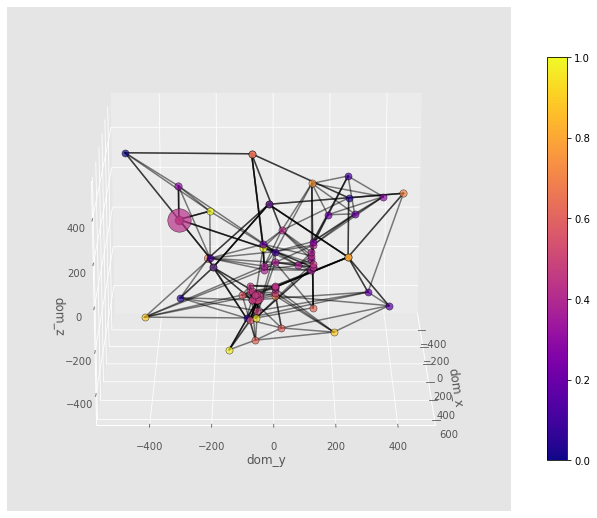

Reading files
Saving dataset
Loading data to memory
Reading files
Saving dataset
Loading data to memory
Reading files
Saving dataset
Loading data to memory
Reading files
Saving dataset
Loading data to memory
Reading files
Saving dataset
Loading data to memory
Reading files
Saving dataset
Loading data to memory
Reading files
Saving dataset
Loading data to memory
Reading files
Saving dataset
Loading data to memory
Reading files
Saving dataset
Loading data to memory
Reading files
Saving dataset
Loading data to memory
Reading files
Saving dataset
Loading data to memory
Reading files
Saving dataset
Loading data to memory
Reading files
Saving dataset
Loading data to memory
Reading files
Saving dataset
Loading data to memory
Reading files
Saving dataset
Loading data to memory
Reading files
Saving dataset
Loading data to memory
Reading files
Saving dataset
Loading data to memory
Reading files
Saving dataset
Loading data to memory
Reading files
Saving dataset
Loading data to memory
Reading file

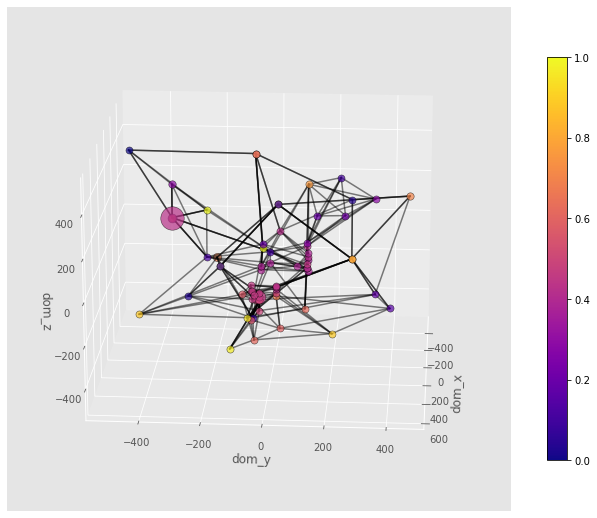

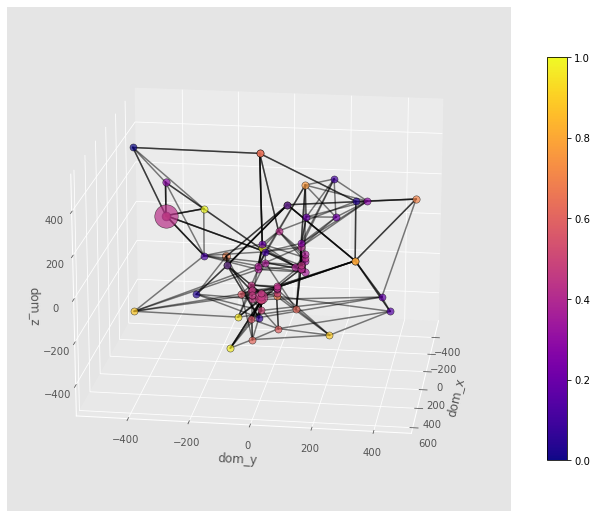

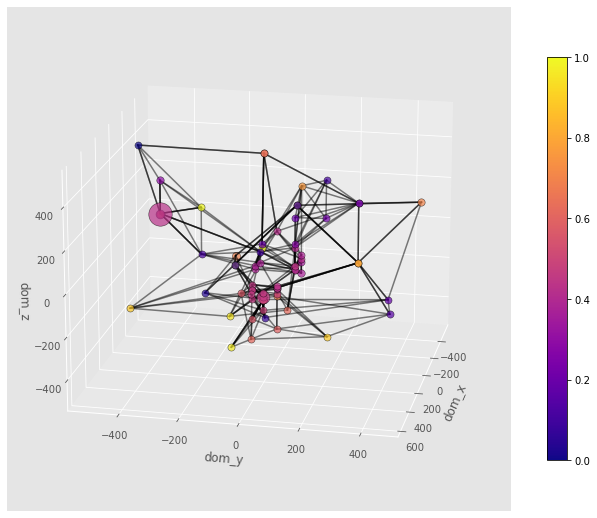

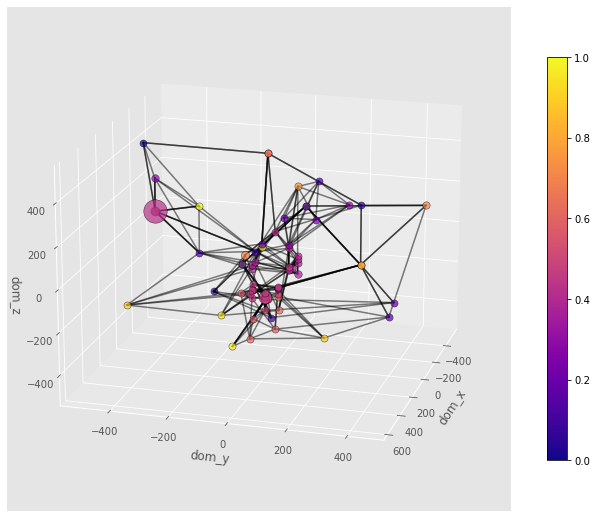

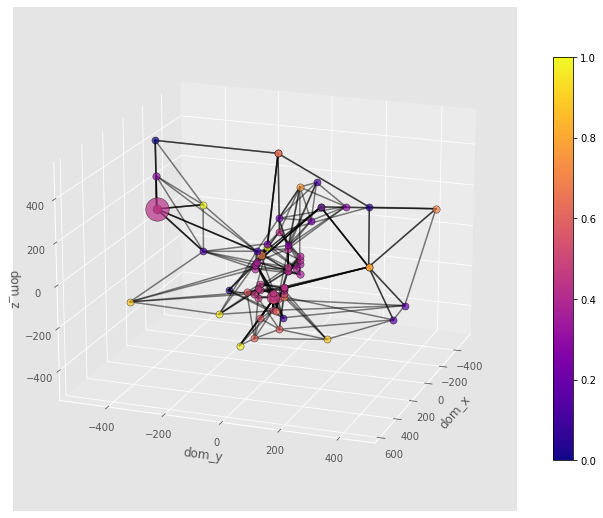

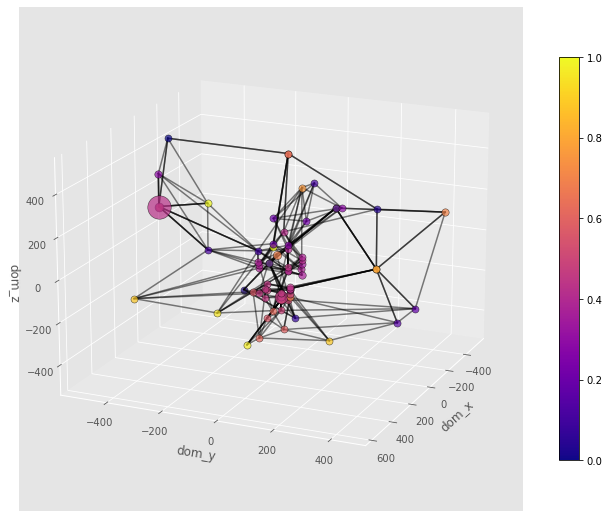

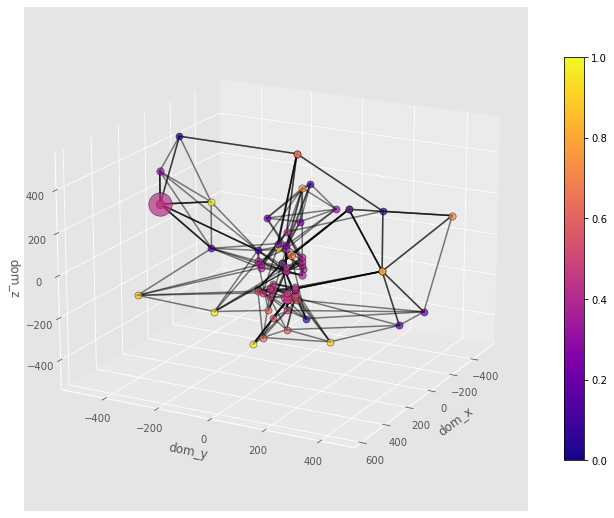

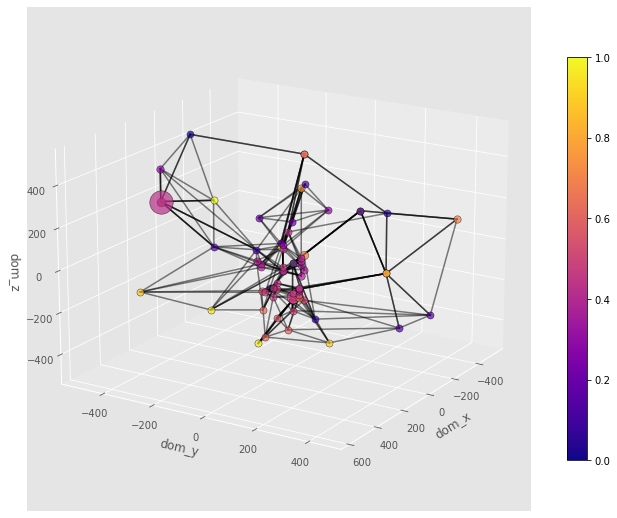

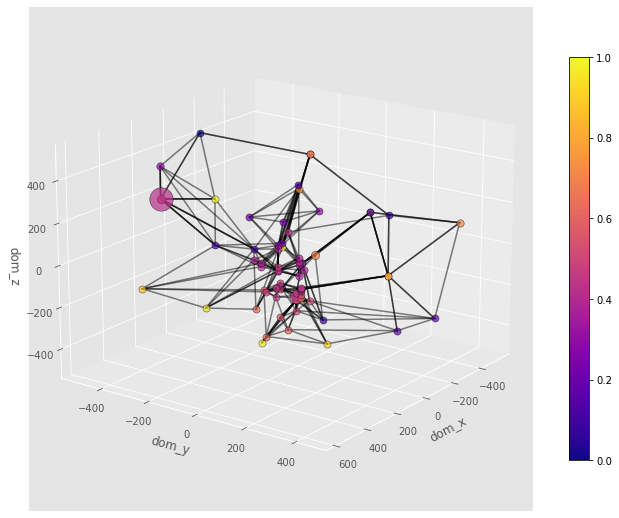

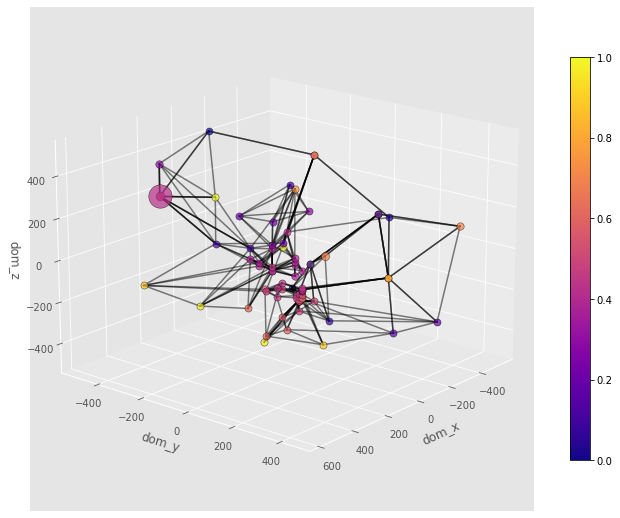

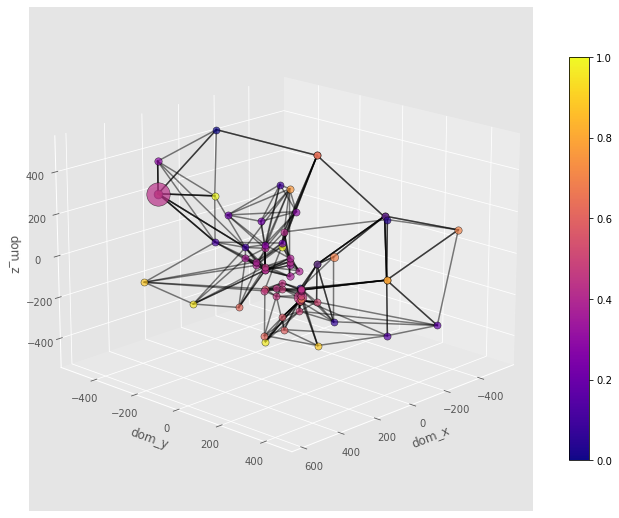

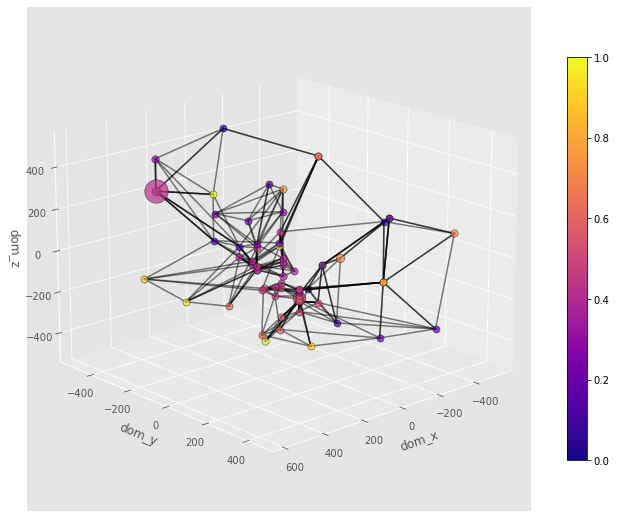

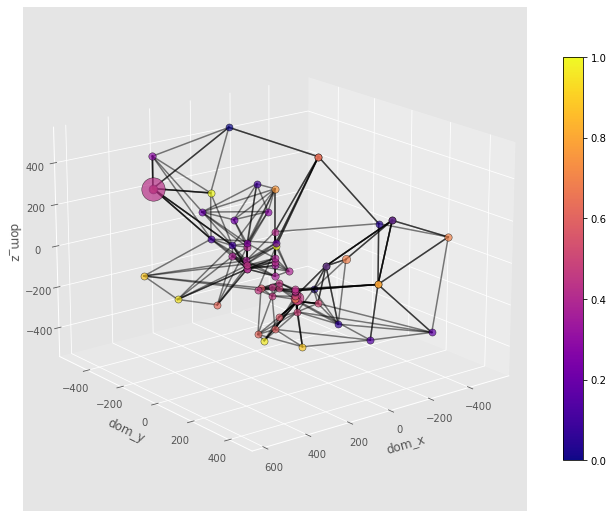

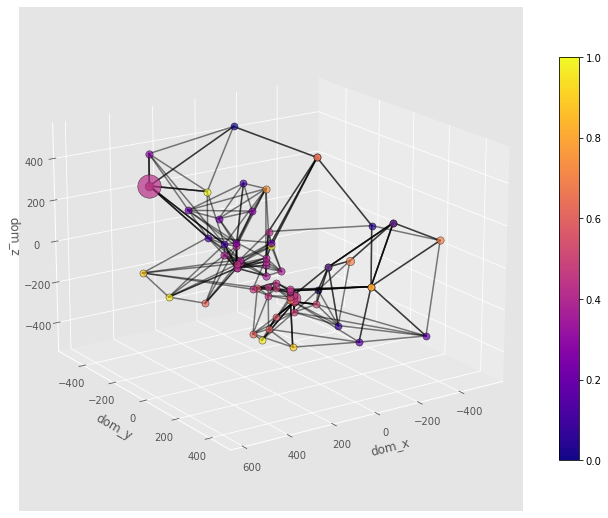

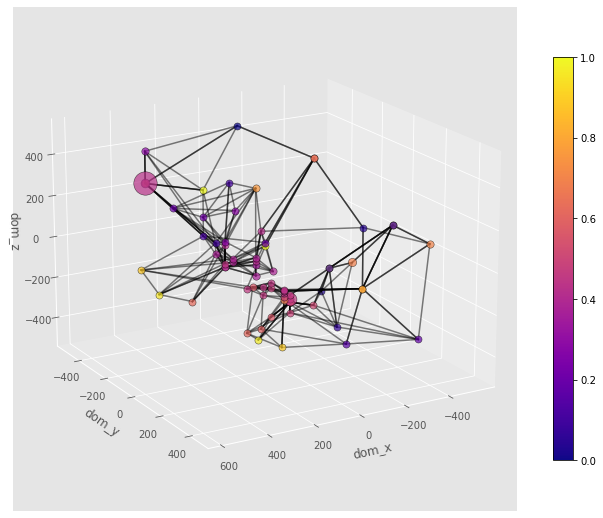

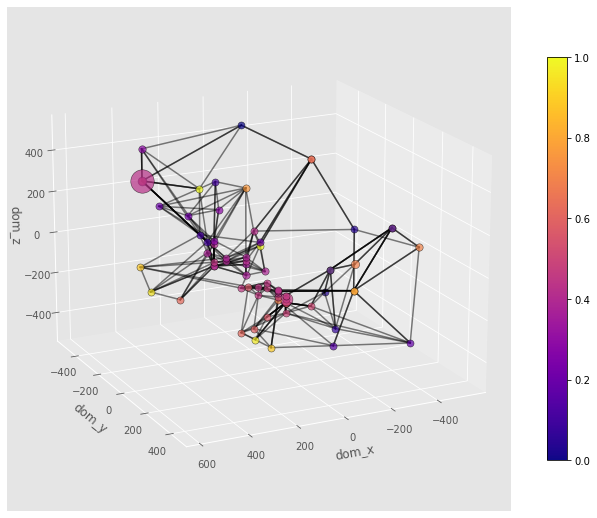

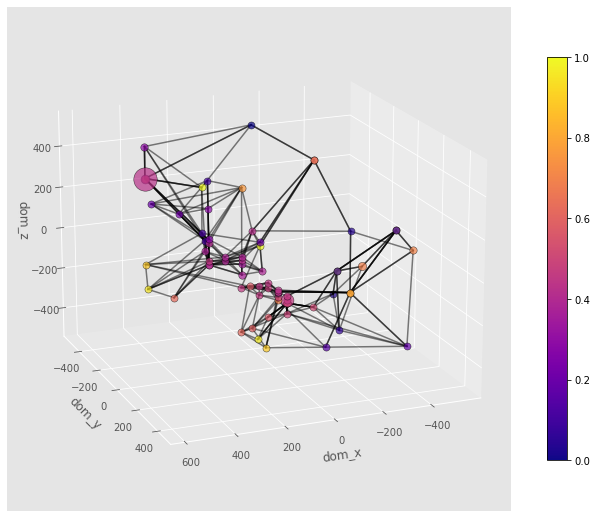

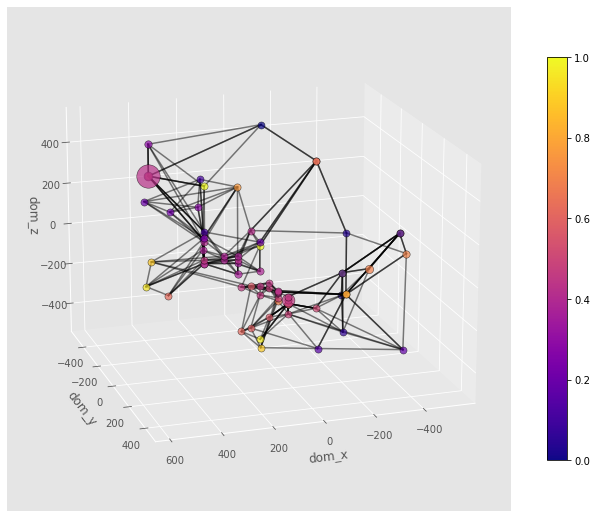

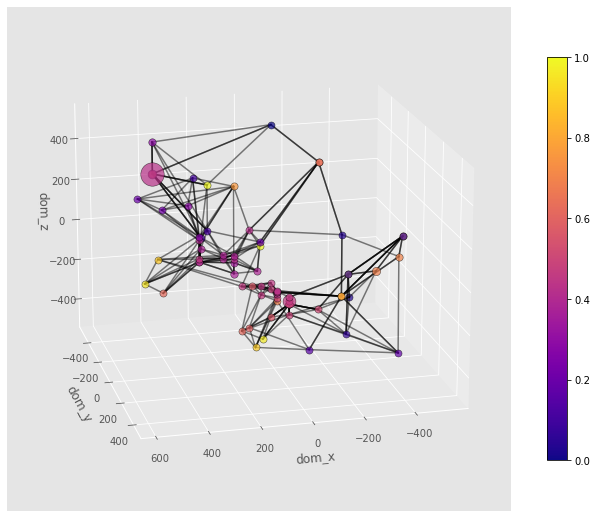

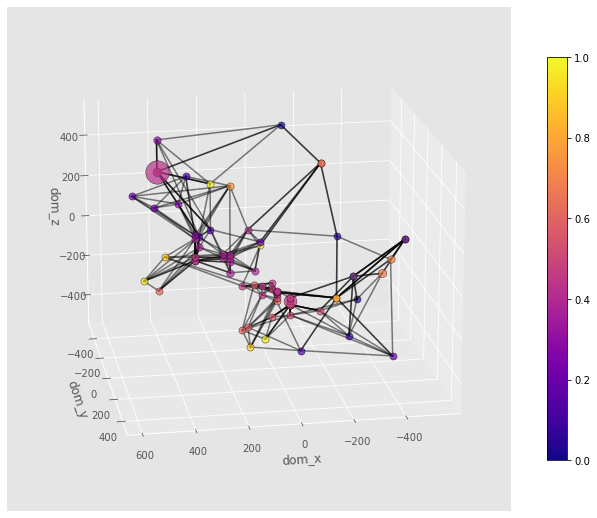

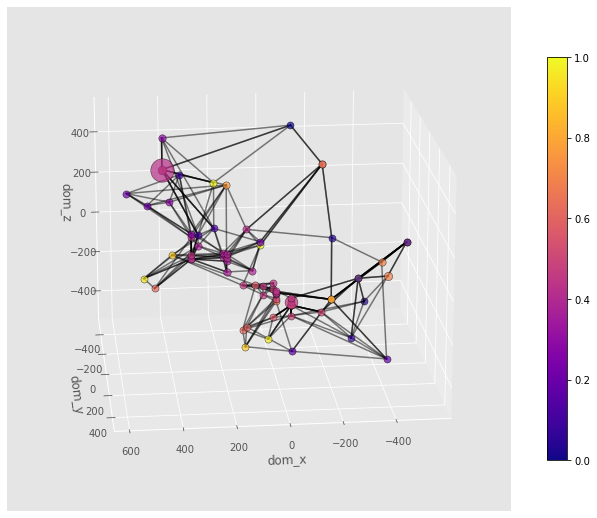

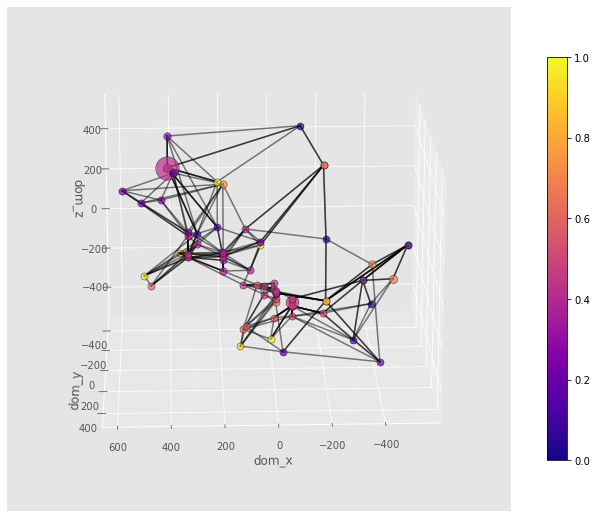

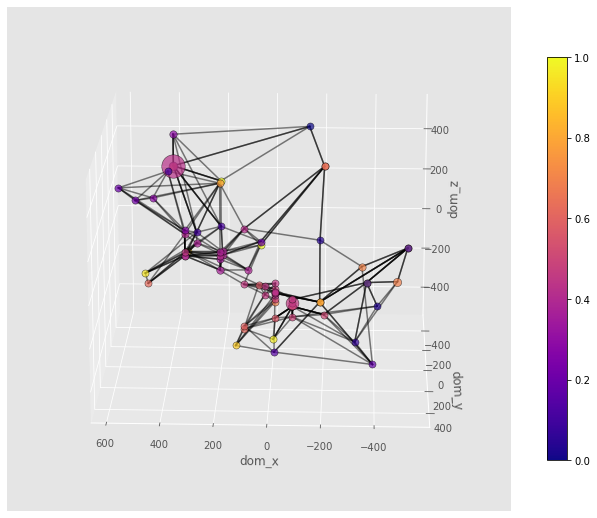

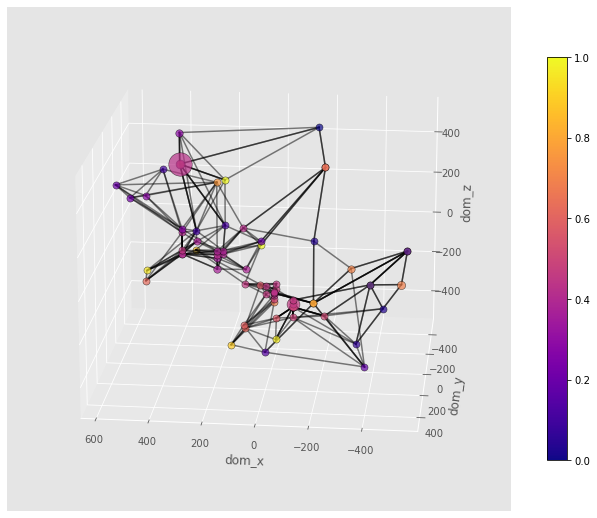

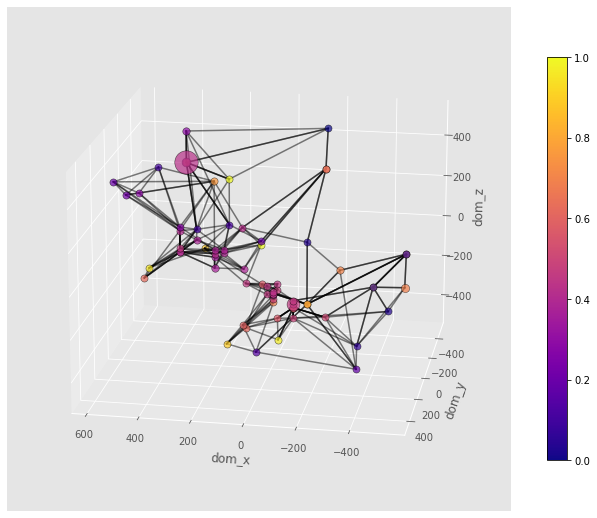

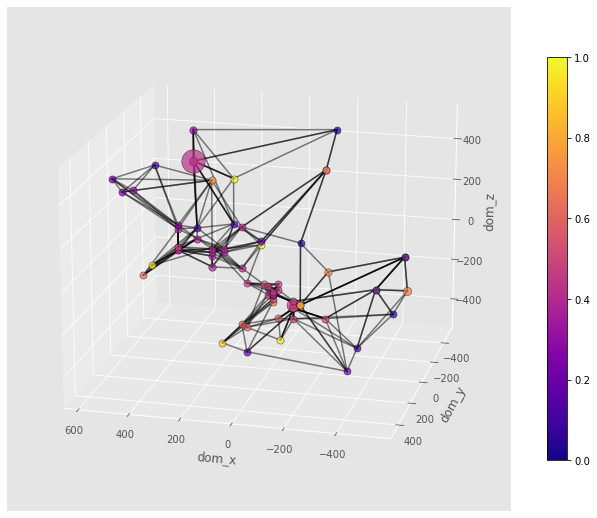

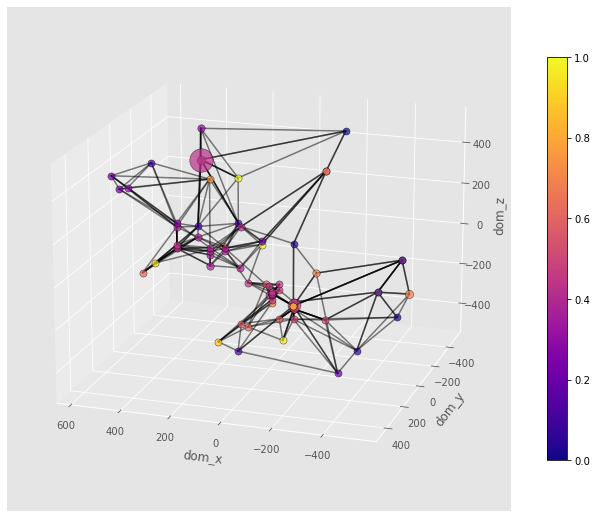

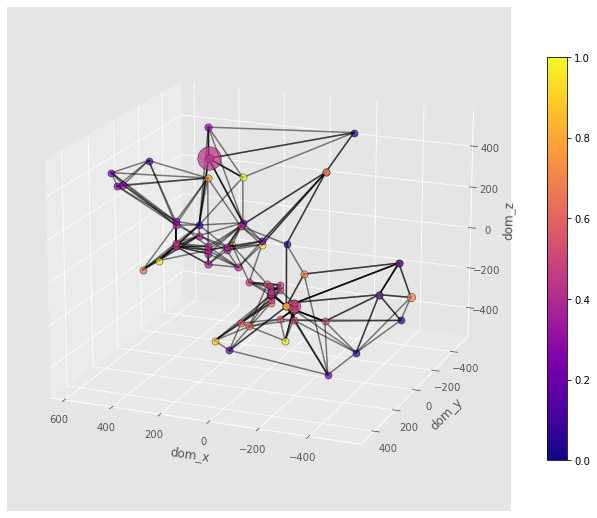

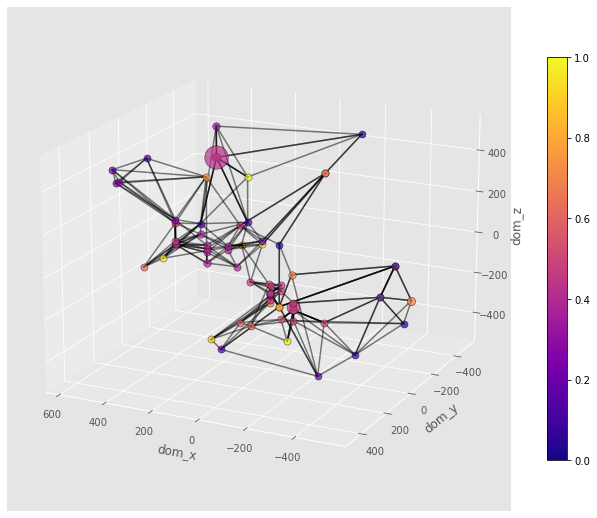

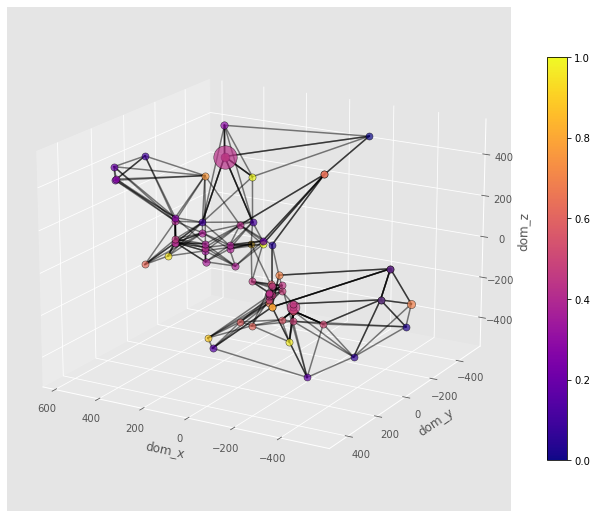

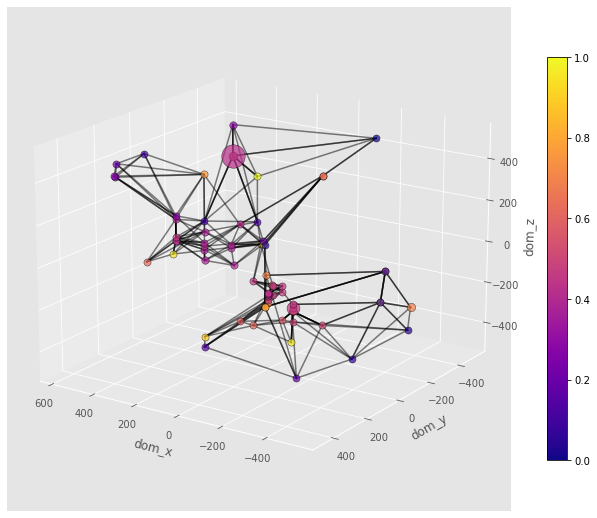

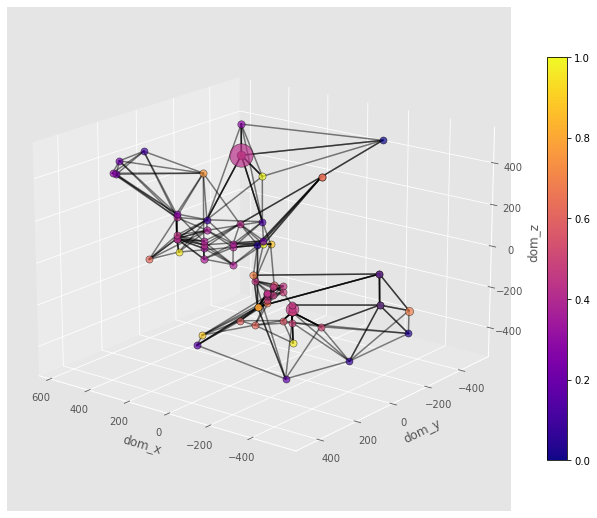

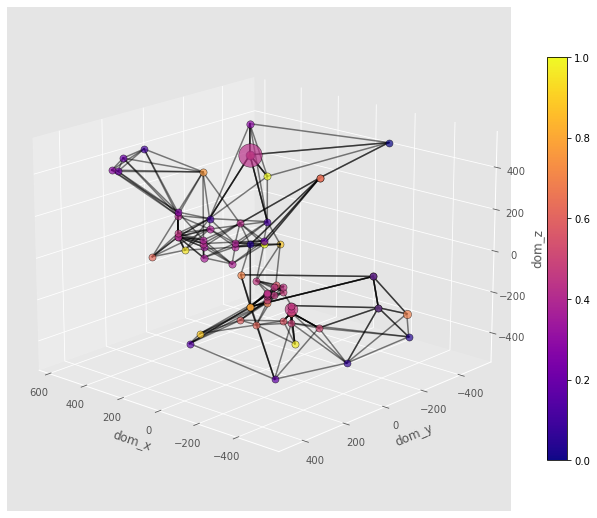

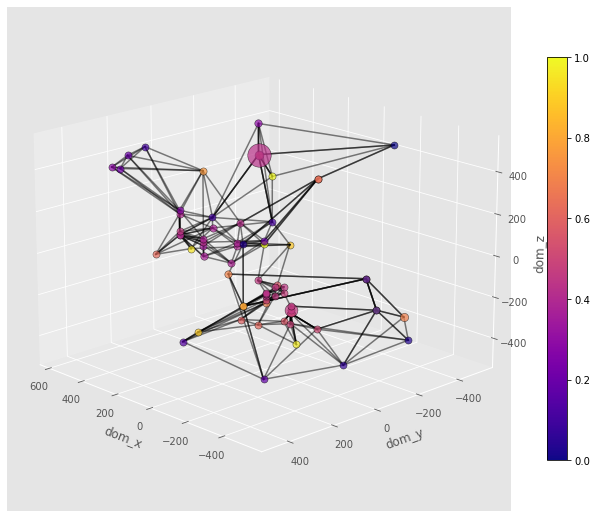

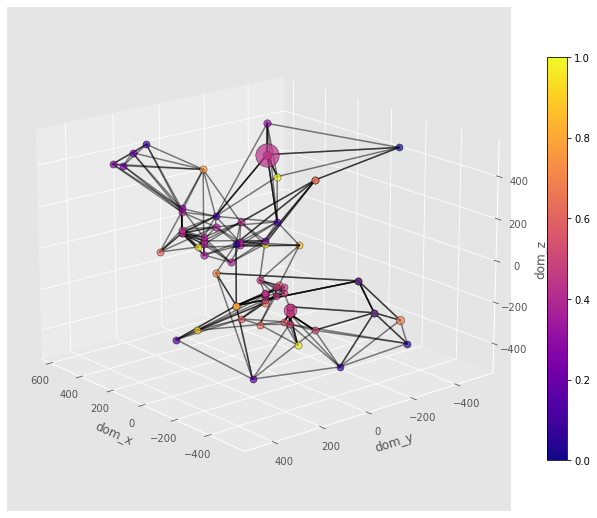

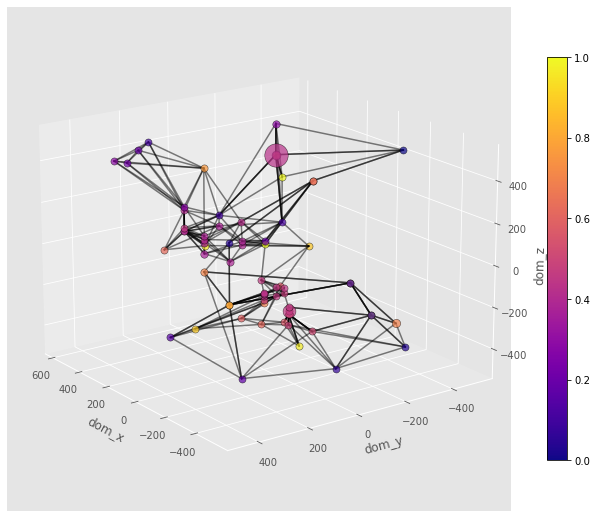

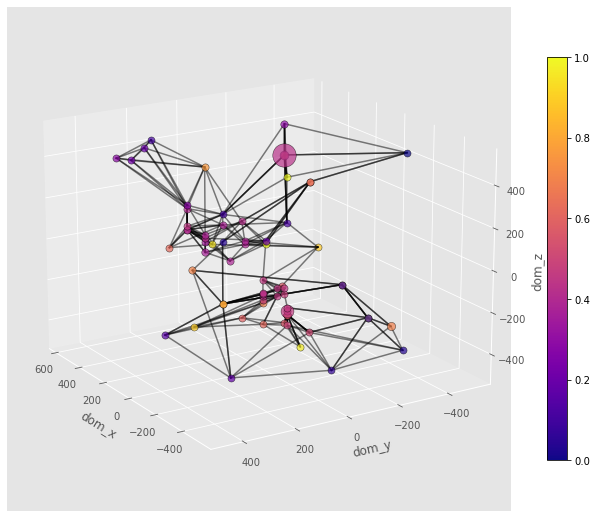

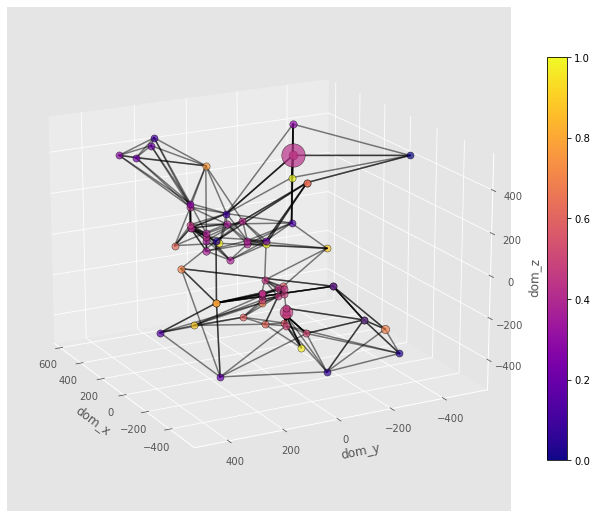

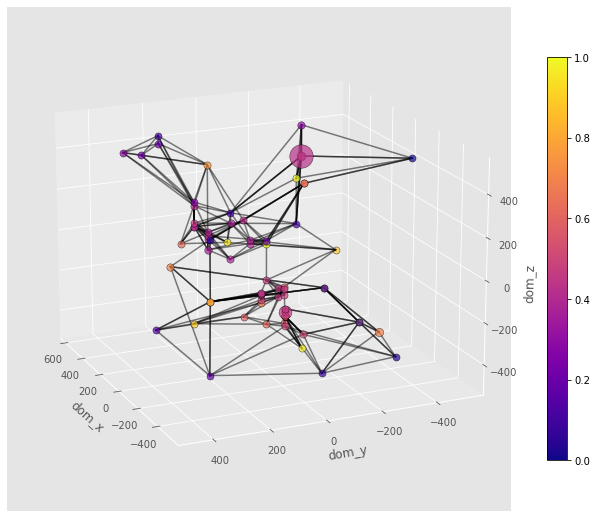

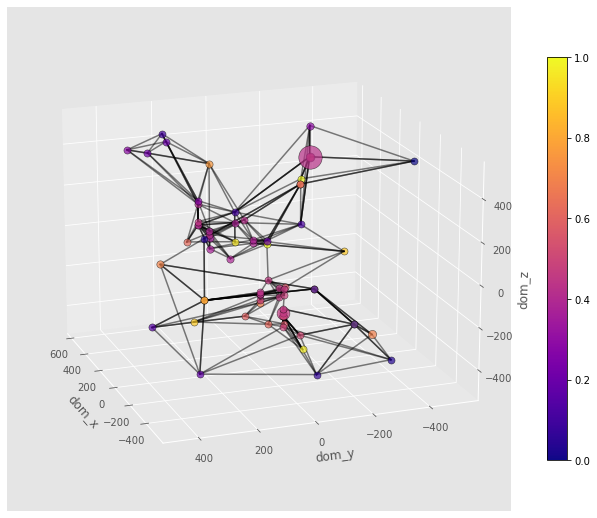

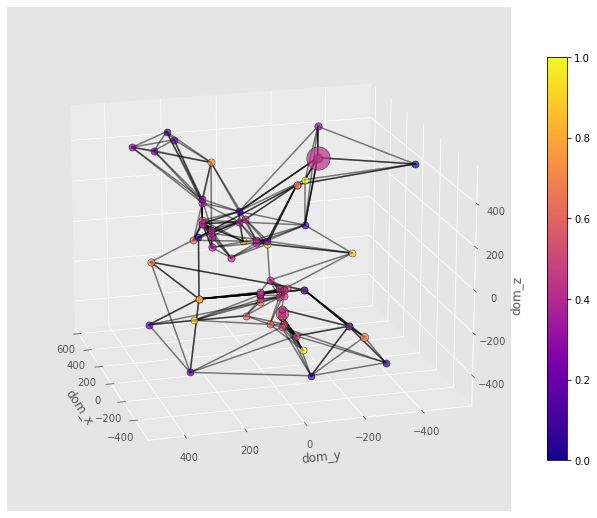

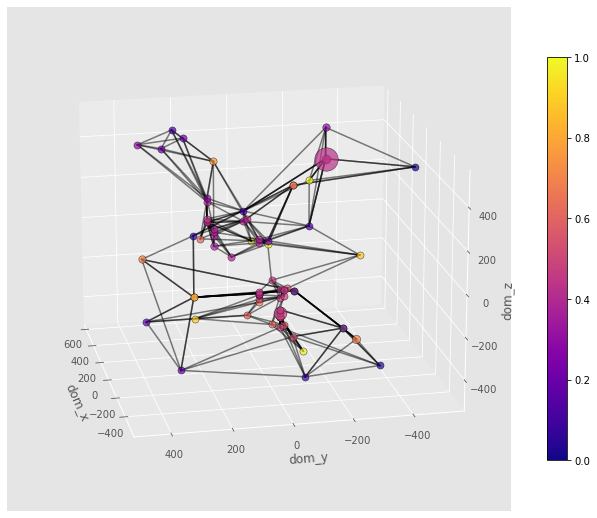

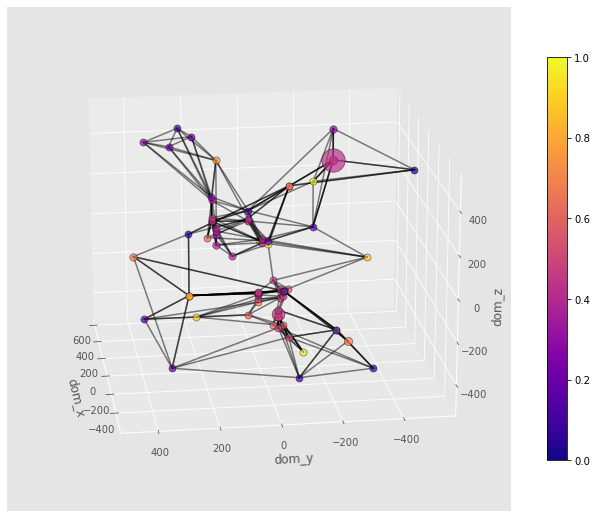

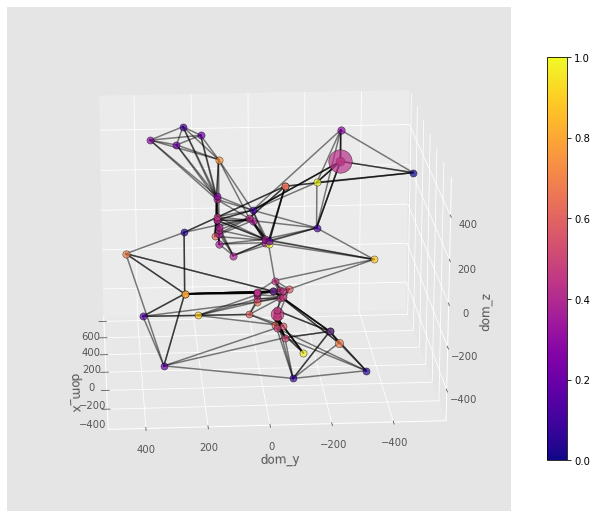

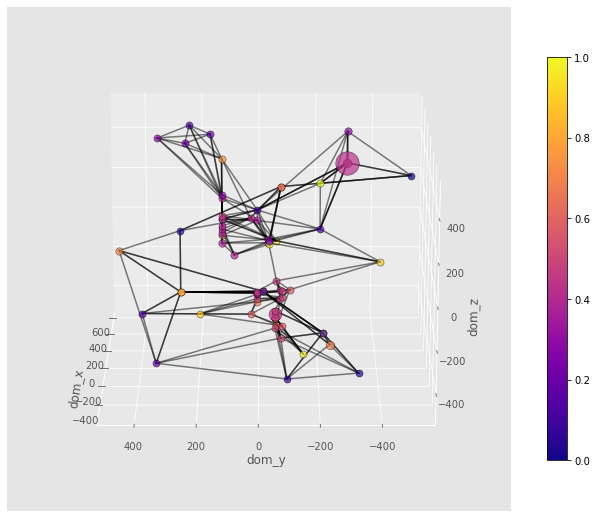

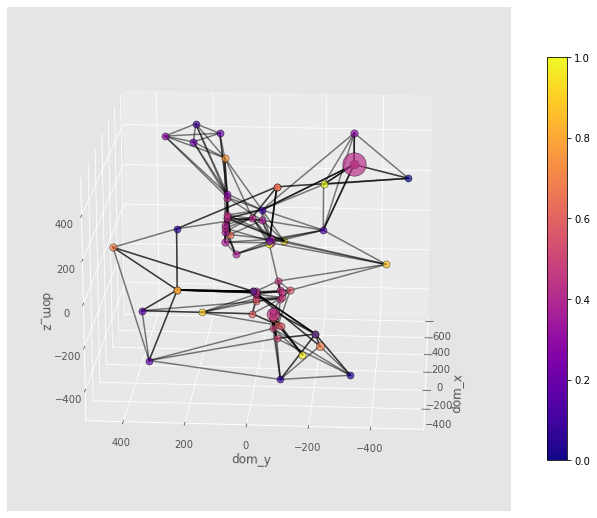

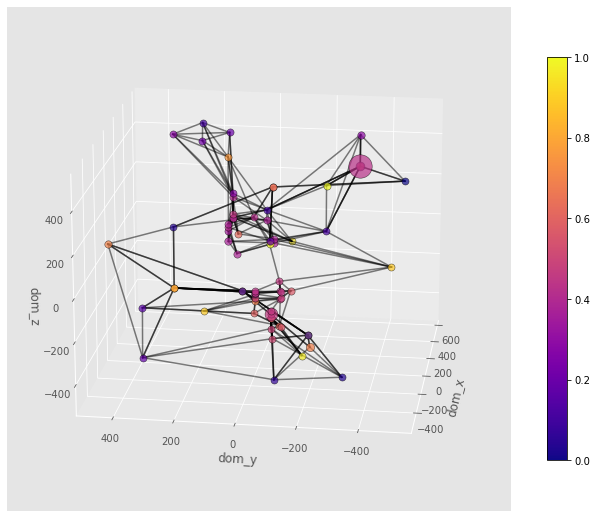

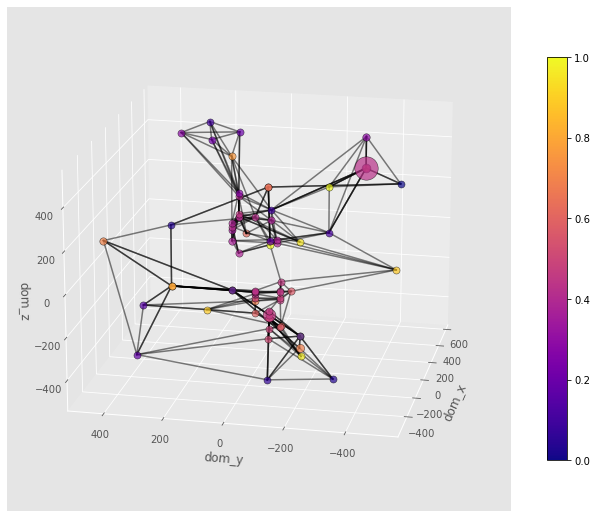

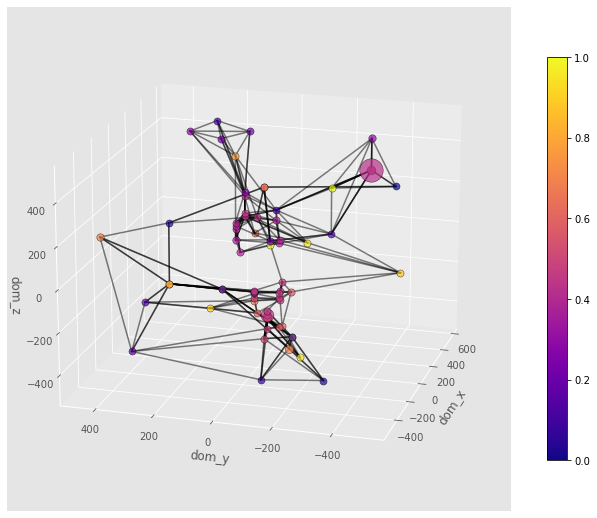

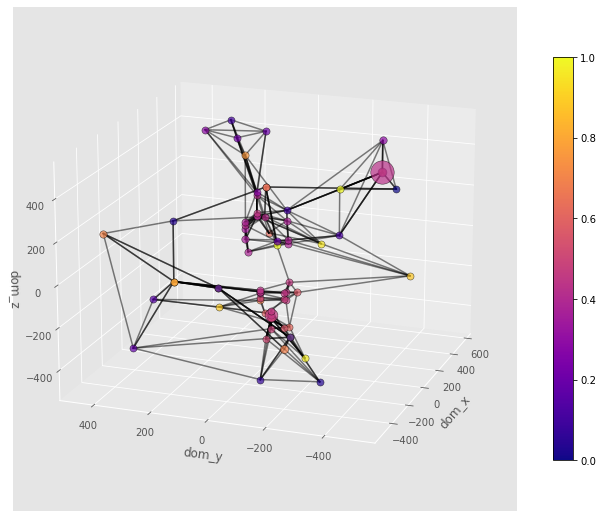

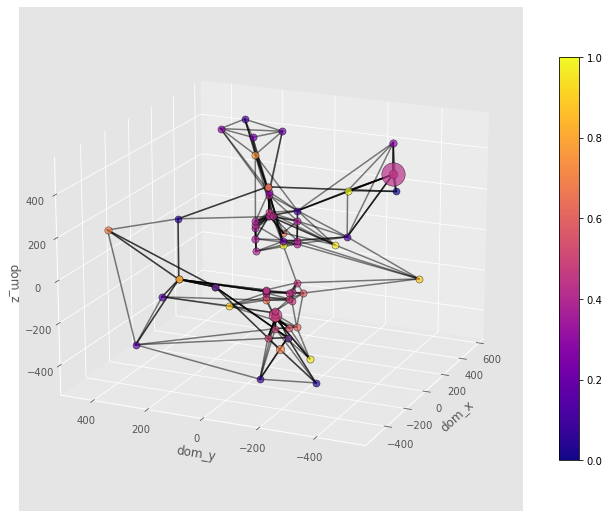

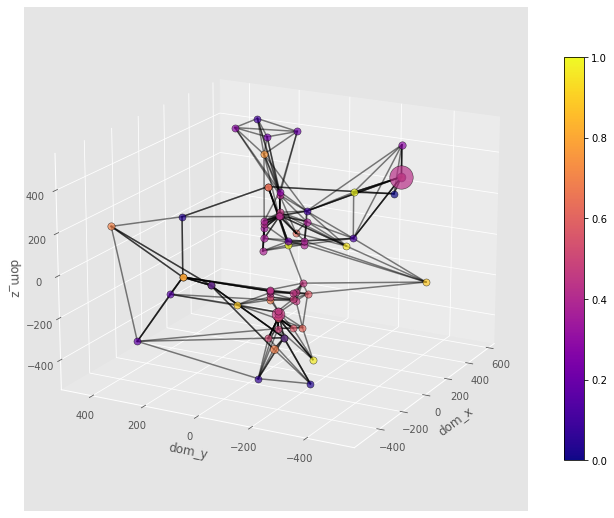

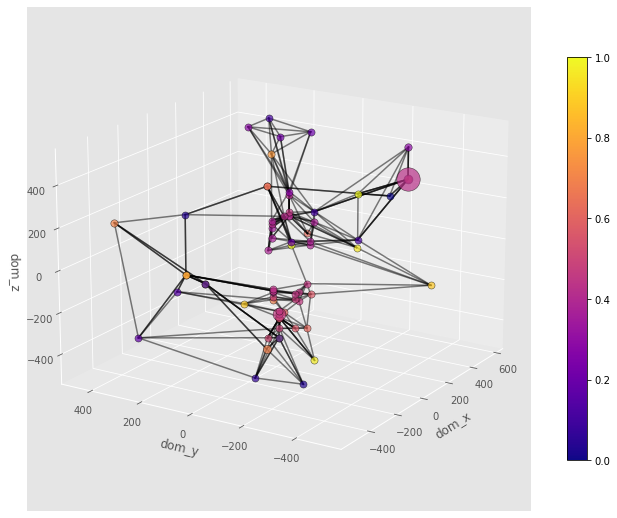

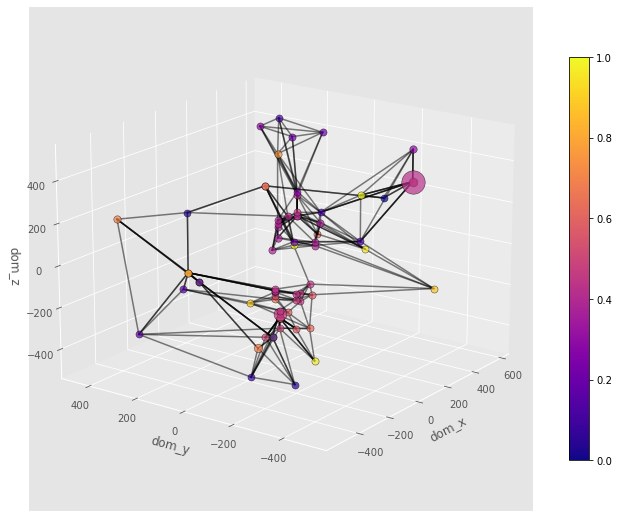

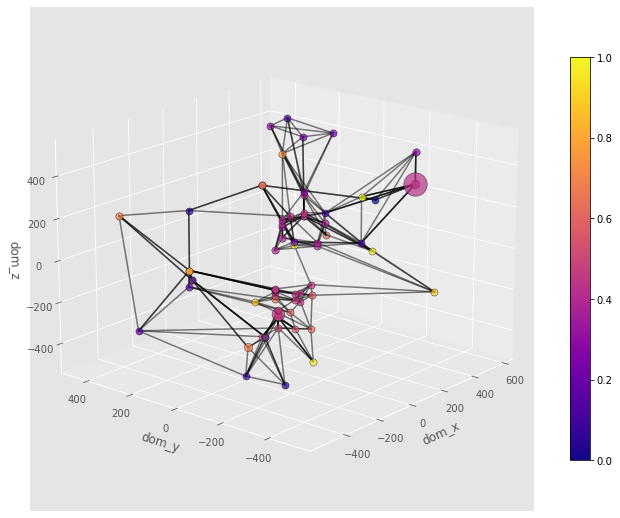

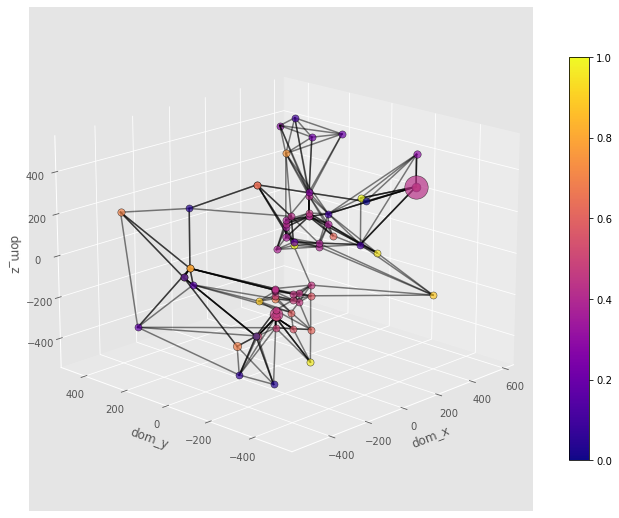

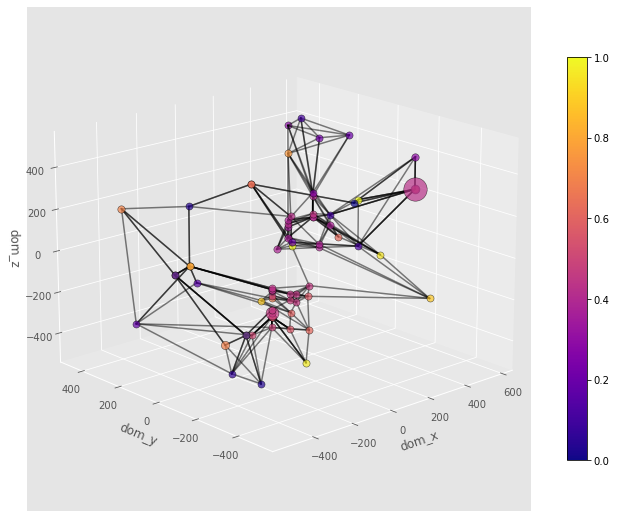

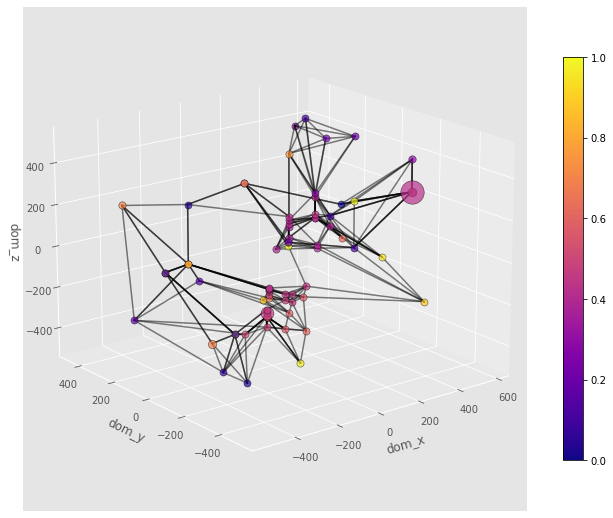

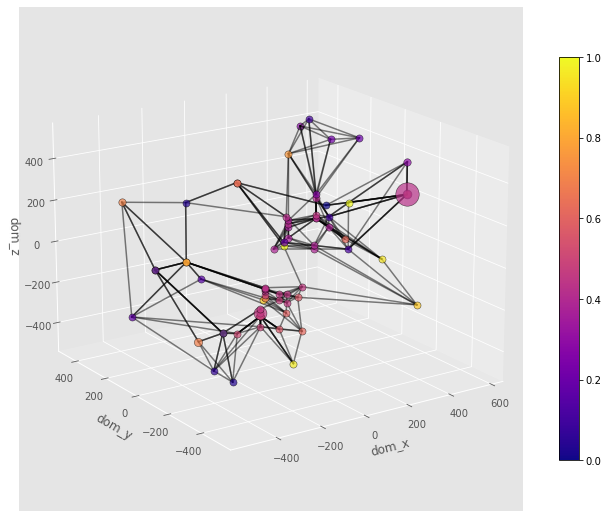

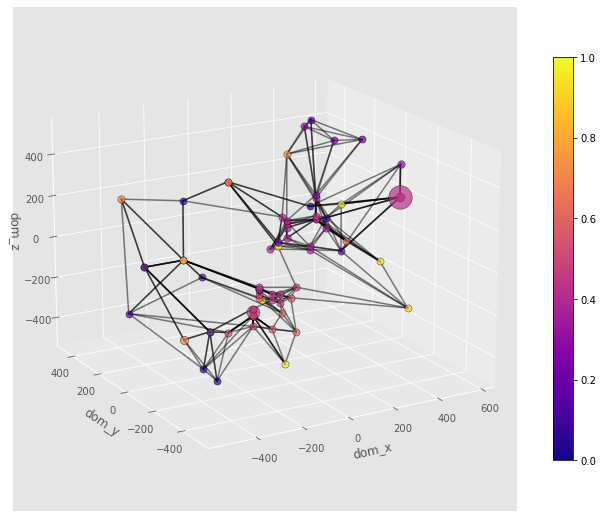

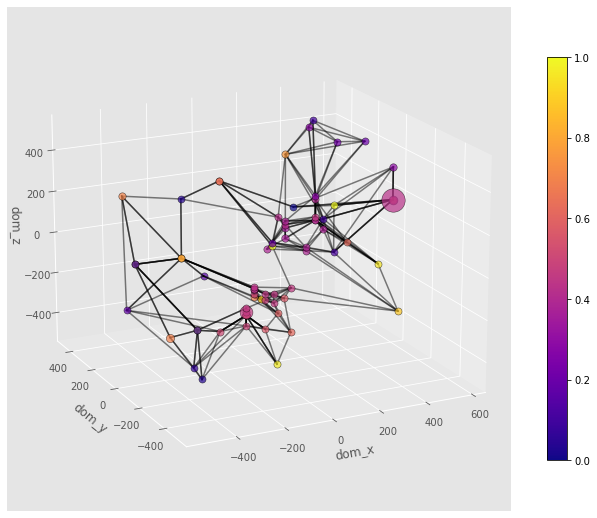

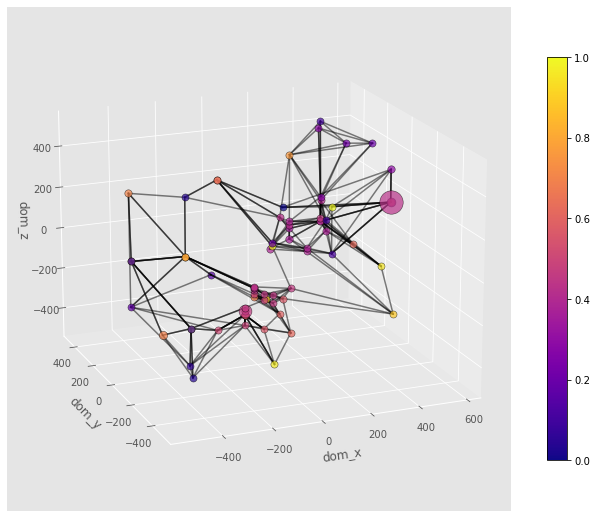

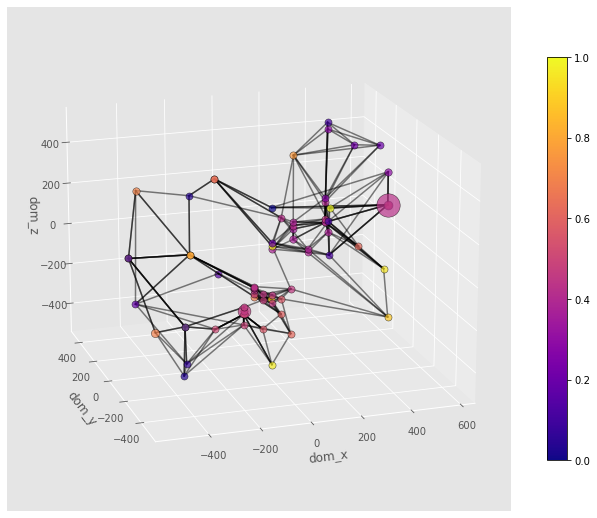

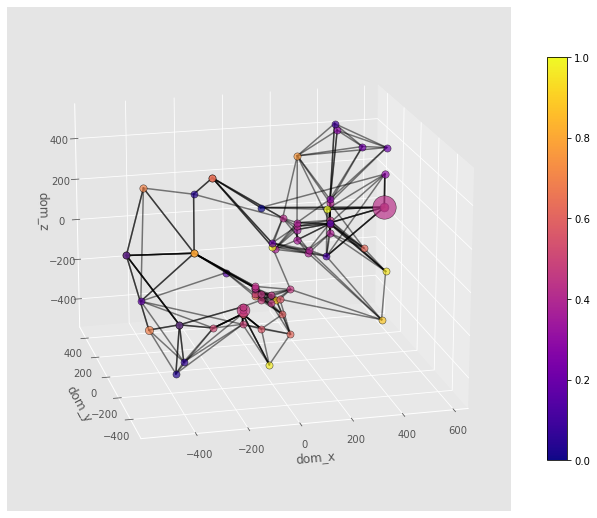

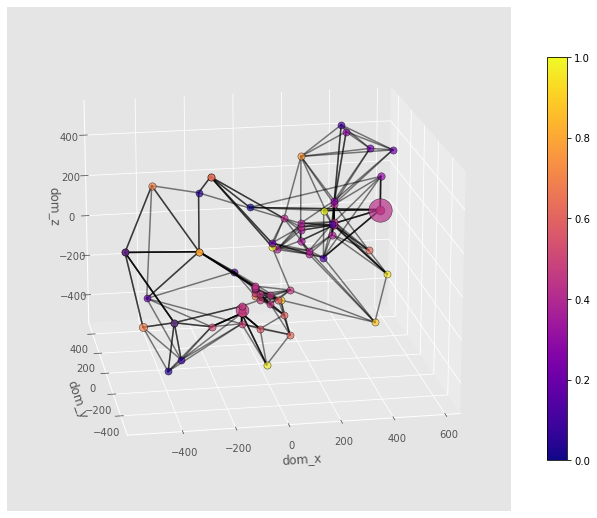

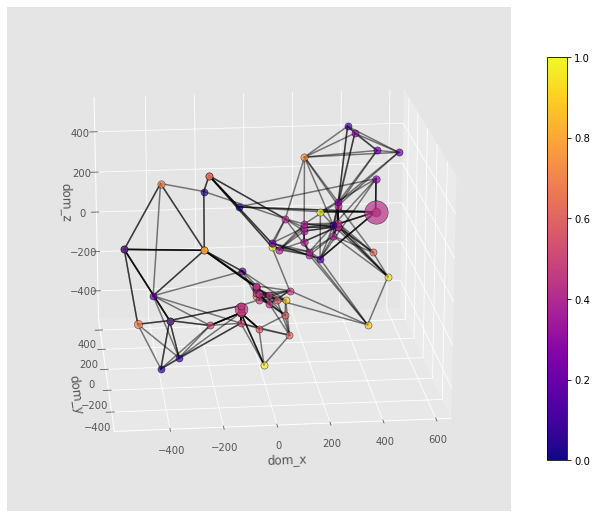

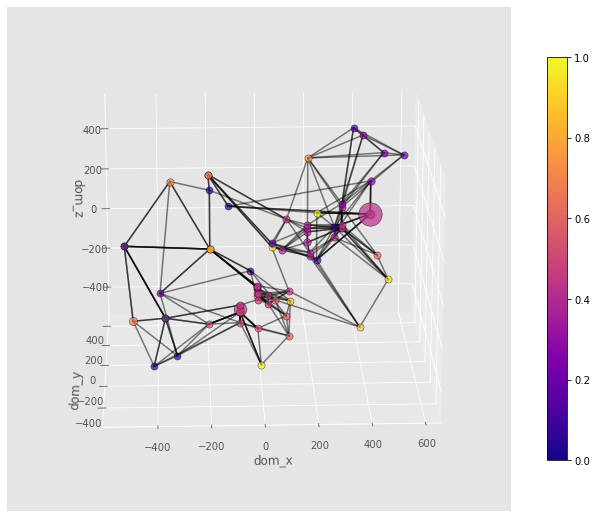

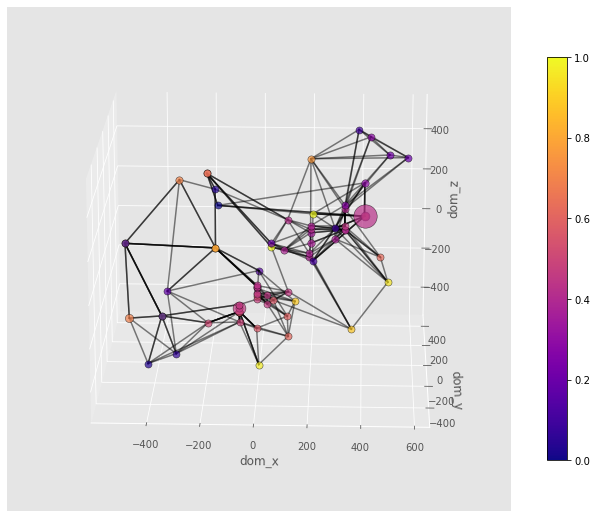

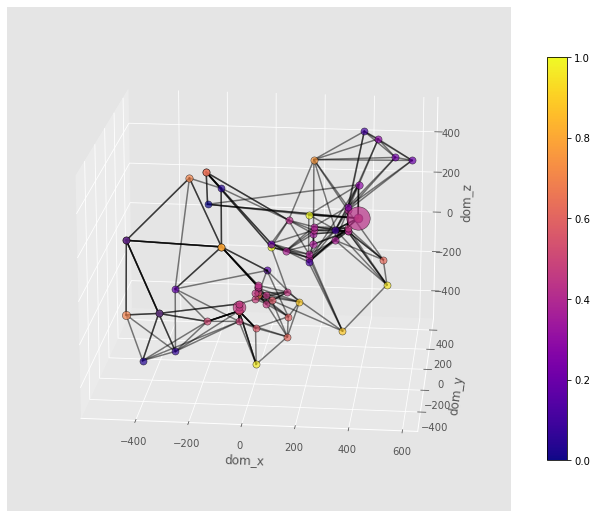

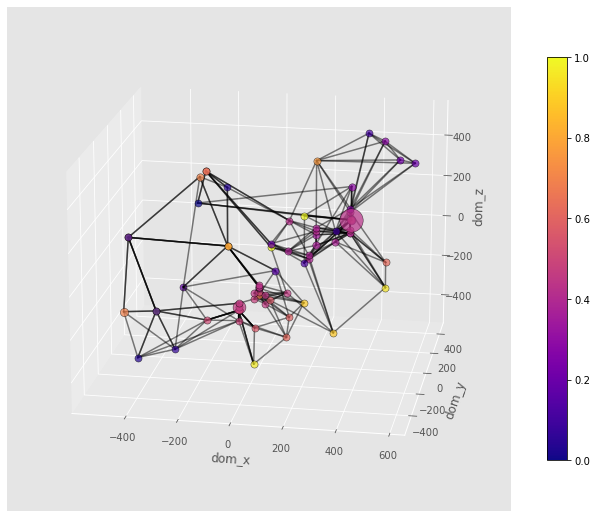

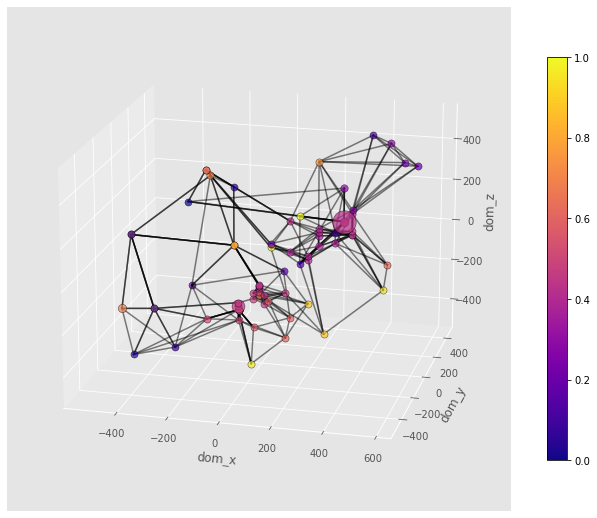

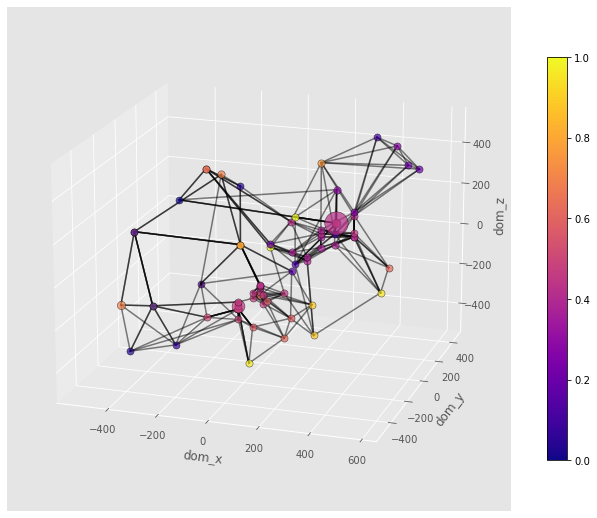

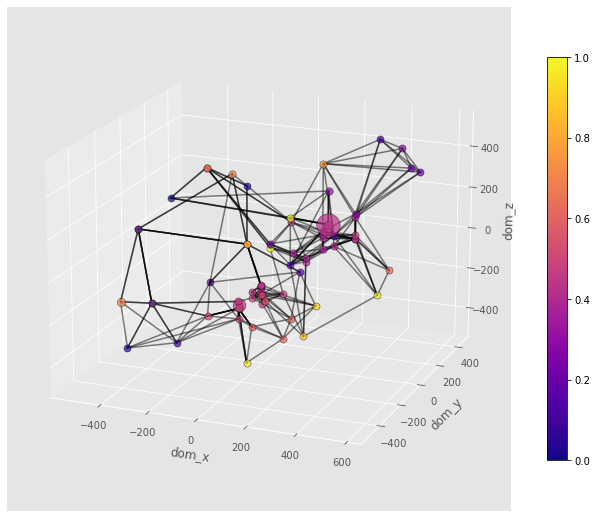

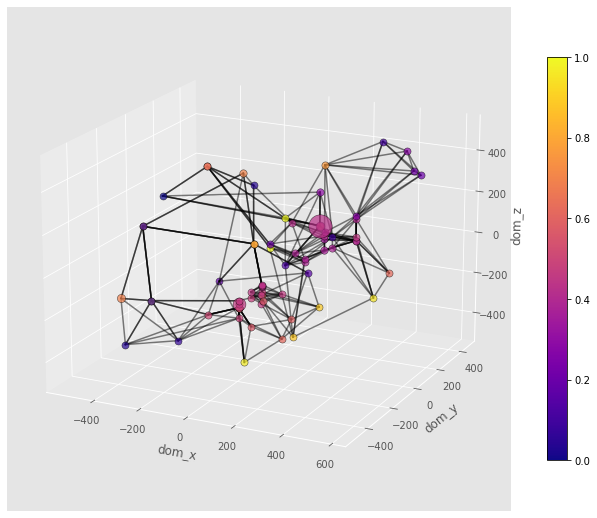

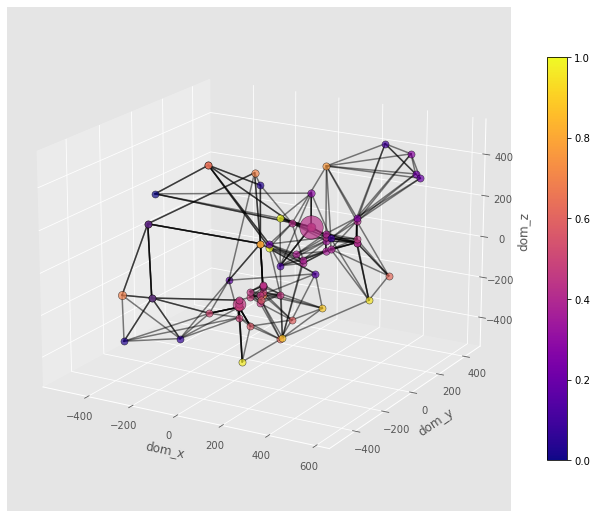

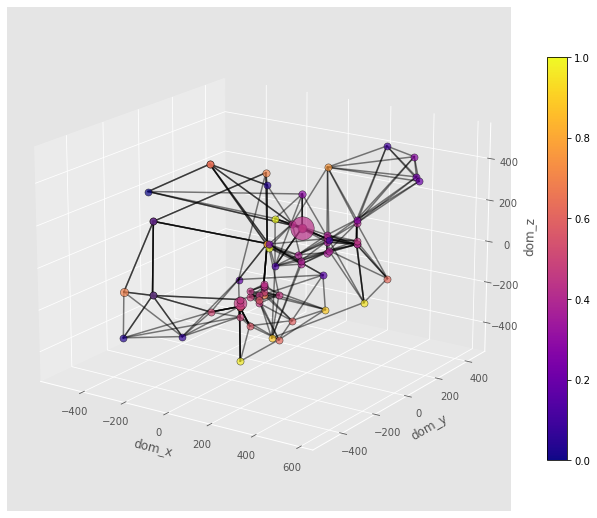

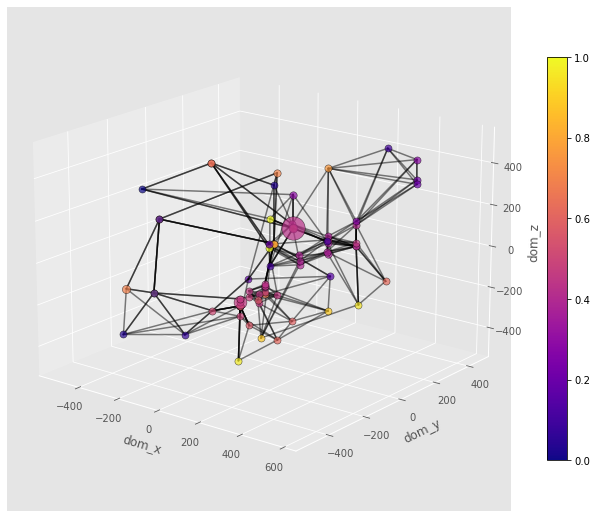

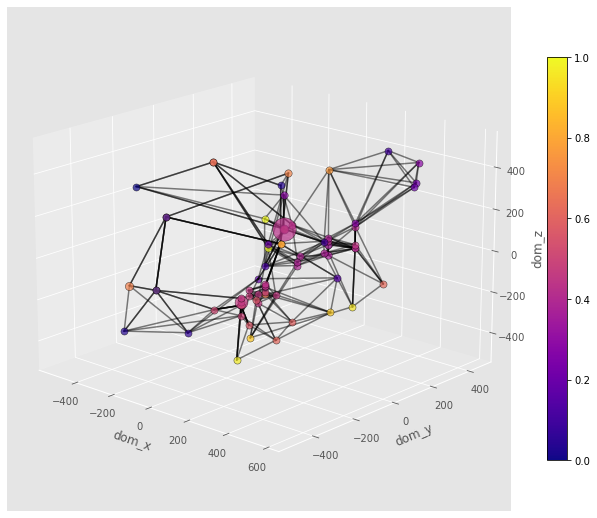

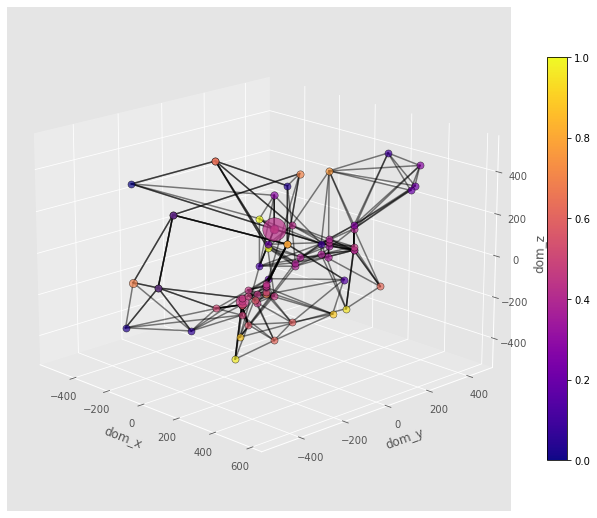

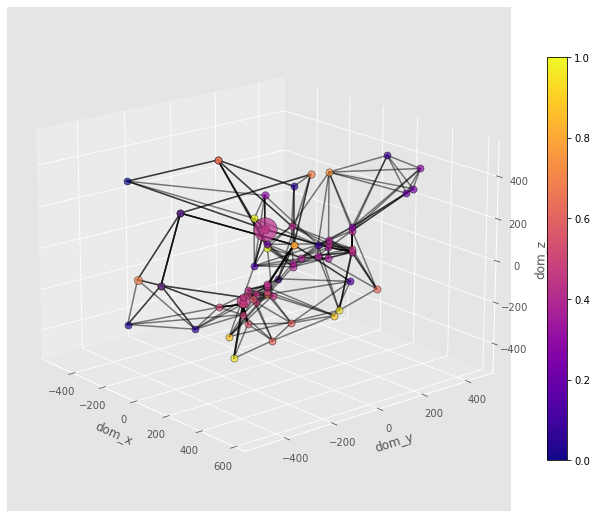

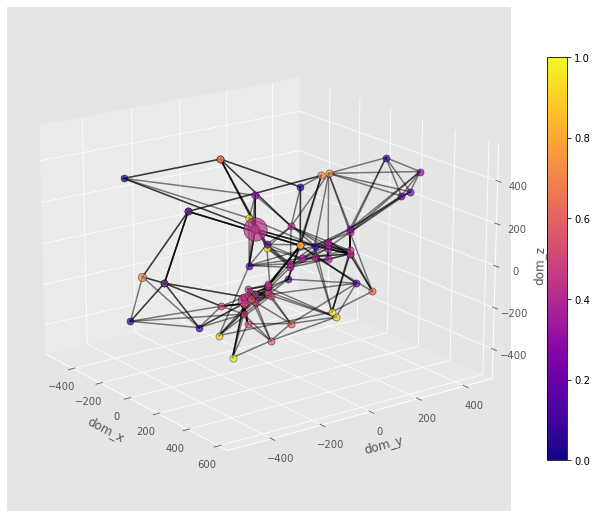

Error in callback <function flush_figures at 0x00000202384F1C10> (for post_execute):


KeyboardInterrupt: 

In [69]:
# %matplotlib notebook
%matplotlib inline
for i in range(0,360,4):
    inspect(1., event_no=138674361, hist=False, save=i, muon=1, angle=i, n_neighbors=6)

In [103]:
'''Module to plot '''
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as scp
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
import numpy as np
import os, sqlite3, pickle, sys, gzip, shutil, time
import os.path as osp

from pandas import read_sql, concat
from sklearn.preprocessing import normalize, RobustScaler
from sklearn.neighbors import kneighbors_graph as knn

from spektral.data import Dataset, Graph

features = ["dom_x", "dom_y", "dom_z", "time", "charge_log10"]
# features = ["dom_x", "dom_y", "dom_z", "dom_time", "charge_log10"]
targets  = ["energy_log10", "zenith","azimuth", "direction_x", "direction_y","direction_z"]

import warnings
warnings.filterwarnings("ignore")
# %matplotlib inline

def gif_inspect(ax, event=0, muon=True, time=0, event_no=None, n_neighbors=20, alpha=0.7, angle=45, save=False, degree=False, hist=False, transform_path='../db_files/MuonGun/transformers.pkl', db_path='../db_files/MuonGun/rasmus_classification_muon_3neutrino_3mio.db'):
    
    '''Plot a graph in 3d, where the colour is determined by time and the size of the point is determined by charge.
        Generally, the only thing you need to do is modify the file path to the db_file in load_event.
        Inspect takes an integer (as just event number x in the database), if not given a specific event_no, which is then loaded in.
        angle specifies the initial angle (azimuthal) to see the plot from. If you plot with matplotlib notebook you can control the angle.
        degree: if True we colour based on node degree and not ti,e
        hist: if true distributions of node features are shown.
        save should be self-explanatory.'''
    dt=load_event(event, event_no, db_path=db_path, n_neighbors=n_neighbors, transform_path=transform_path, muon=muon)[0]
    X, A, Y=dt.x, dt.a, dt.y
    if hist:
        fig1, ax1=plt.subplots(nrows=1, ncols=5, figsize=(10,4))
        for i in range(len(X[0])):
            ax1[i].hist(X[:,i], histtype='step')
            ax1[i].set(xlabel=features[i], yscale='log')
        fig1.tight_layout()
    ix, iy,_=scp.find(A)
    adj=list(zip(ix,iy))
    G=nx.Graph()
    for i in np.arange(len(X[:,0])):
        G.add_node(i, x=X[i,0], y=X[i,1], z=X[i,2], t=X[i,3], q=X[i,4], pos2d=[X[i,0], X[i,1]] ,pos3d=[X[i,0], X[i,1],X[i,2]])
    G.add_edges_from(adj)
    plot_3d(G, Y, angle=angle, ax=ax, time=time, save=save, degree=degree, alpha=alpha)


def plot_3d(G,Y, ax, angle=45, time=time, save=False, degree=False, alpha=0.7):
    # Get node positions
    pos = nx.get_node_attributes(G, 'pos3d')
    ts = nx.get_node_attributes(G, 't')
    qs = nx.get_node_attributes(G, 'q')
    # Get number of nodes
    n = G.number_of_nodes()
    # Get the maximum number of edges adjacent to a single node
    edge_max = max([G.degree(i) for i in range(n)])
    # Define color range proportional to number of edges adjacent to a single node
    mint=min(ts.items(), key=lambda x: x[1])[1]
    maxt=max(ts.items(), key=lambda x: x[1])[1]
#     print(mint, ts.items())
    tlist=[np.log(t)-np.log(mint) for key, t in ts.items()]
    tlist=[(t-mint)/(maxt-mint) for key, t in ts.items()]
    keylist=[key for key, t in ts.items()]
    global times
    times=np.vstack([tlist, keylist]).T
    times=times[np.argsort(times[:, 0])]

    colors=plt.cm.plasma(tlist)
    # 3D network plot
    central=np.array(list(nx.degree_centrality(G).values()))
    connect=nx.is_connected(G)
#     print(colors)
    with plt.style.context(('ggplot')):

        # Loop on the pos dictionary to extract the x,y,z coordinates of each node
        xs,ys,zs,keys=[],[],[],[]
        for key, value in pos.items():
            xs.append(value[0])
            ys.append(value[1])
            zs.append(value[2])
            keys.append(key)
            # Scatter plot
        key=int(times[:,1][time])
        mapa=ax.scatter(pos[key][0], pos[key][1], pos[key][2], c=[colors[key]], s=50+10**(4*qs[key]), edgecolors='k', depthshade=1, alpha=alpha)
        if time==0:
#             cbar=fig.colorbar(plt.cm.ScalarMappable(norm=mpl.colors.Normalize(), cmap=plt.cm.plasma), ax=ax, shrink=0.8)
            c=1200
            c1=400
            ax.plot( [c1,-0.665621*c], [c1/2,-0.301861*c], [c1,    -0.682516*c], color='k', linestyle='dashed')
        # Plot the connecting lines
    
    # Set the initial view
    ax.view_init(18, angle)
    n_nodes, n_edges=G.number_of_nodes(), G.number_of_edges()

#         ax.plot(c1, c1/2, c1, -0.665621*c,    -0.301861*c,    -0.682516*c, color='k')
    ax.set(xlabel='dom_x', ylabel='dom_y', zlabel='dom_z')
#     info=f'E: {10**Y[0]:.2f} GeV, Zenith: {Y[1]*180/np.pi:.2f}, Azimuth: {Y[2]*180/np.pi:.2f}, DOMs: {n_nodes}'
#     ax.set(title=info)
    if save:
        fig.savefig(f'../../figs_thesis/gif_base/graph3dtest_{np.round(angle,2)}.png')
#      plt.close('all')
    else:
      plt.show()
    return


class load_event(Dataset):
    """
    just to load event, important part is that you can either just pick an event_no or just an event by just any integer (of course in the set)
    """

    def __init__(self, event=0, event_no=None, transform=True, muon = True, n_neighbors = 6, transform_path='../db_files/MuonGun/transformers.pkl', db_path='../db_files/MuonGun/rasmus_classification_muon_3neutrino_3mio.db', restart=True, **kwargs):
        self.skip   = event
        self.event_no = event_no
        self.n_neighbors = n_neighbors
        self.seed = 42
        self.transform_path=transform_path
        self.transform=transform
        self.restart=restart
        self.muon=muon
        self.k=0
        self.db_path=db_path
        super().__init__(**kwargs)

    @property
    def path(self):
        """
        Set the path of the data to be in the processed folder
        """
        cwd = osp.abspath('')
        path = osp.join(cwd, "processed/graph_dataset")
        return path

    def reload(self):
        if os.path.isdir(self.path):
            shutil.rmtree(self.path)
            print('Removed and ready to reload')

    def download(self):
        download_start = time.time()
        # Get raw_data
        db_file   = self.db_path

        # Make output folder
        os.makedirs(self.path)

        print("Connecting to db-file")
        feature_call = ", ".join(features)
        target_call  = ", ".join(targets)
        with sqlite3.connect(db_file) as conn:
            if self.event_no is None:
                # Find indices to cut after
                try:
                    if self.muon:
                        print('Loading Muons')
                        start_id = conn.execute(f"select distinct event_no from features where event_no > 138674340 limit 1 offset {self.skip}").fetchall()[0][0]
                        stop_id  = conn.execute(f"select distinct event_no from features where event_no > 138674340 limit 1 offset {self.skip + 1}").fetchall()[0][0]
                    else:
                        print('Loading Neutrinos')
                        start_id = conn.execute(f"select distinct event_no from features limit 1 offset {self.skip}").fetchall()[0][0]
                        stop_id  = conn.execute(f"select distinct event_no from features limit 1 offset {self.skip + 1}").fetchall()[0][0]
                except:
                    ""
                    start_id = 0
                    stop_id  = 999999999

                # Load data from db-file
                print("Reading files")
                self.index=start_id
                df_event = read_sql(f"select event_no from features where event_no >= {start_id} and event_no < {stop_id}", conn)
                df_feat  = read_sql(f"select {feature_call} from features where event_no >= {start_id} and event_no < {stop_id}", conn)
                df_targ  = read_sql(f"select {target_call } from truth    where event_no >= {start_id} and event_no < {stop_id}", conn)
            else:
                # Load data from db-file
                print("Reading files")
                df_event = read_sql(f"select event_no       from features where event_no == {self.event_no}", conn)
                df_feat  = read_sql(f"select {feature_call} from features where event_no == {self.event_no}", conn)
                df_targ  = read_sql(f"select {target_call } from truth    where event_no == {self.event_no}", conn)
            
            if self.transform:
                transformers = pickle.load(open(self.transform_path, 'rb'))
                trans_x      = transformers['features']
                trans_y      = transformers['truth']


                for col in df_feat.columns:
                    df_feat[col] = trans_x[col].inverse_transform(np.array(df_feat[col]).reshape(1, -1)).T

                for col in df_targ.columns:
                    df_targ[col] = trans_y[col].inverse_transform(np.array(df_targ[col]).reshape(1, -1)).T

            idx_list    = np.array(df_event)
            x_not_split = np.array(df_feat)

            _, idx, counts = np.unique(idx_list.flatten(), return_index = True, return_counts = True) 
            xs          = np.split(x_not_split, np.cumsum(counts)[:-1])

            ys          = np.array(df_targ)
            print(df_targ)
            # Generate adjacency matrices
            print("Generating adjacency matrices")
            graph_list = []
            for x, y in zip(xs, ys):
                a = knn(x[:, :3], self.n_neighbors)

                graph_list.append(Graph(x = x, a = a, y = y))

            graph_list = np.array(graph_list, dtype = object)


            print("Saving dataset")
            pickle.dump(graph_list, open(osp.join(self.path, "inspect_event.dat"), 'wb'))

        
    def read(self):
        if self.restart and self.k==0:
            self.reload()
            self.download()
            self.k+=1
        print("Loading data to memory")
        data   = pickle.load(open(osp.join(self.path, "inspect_event.dat"), 'rb'))
        if self.event_no is not None:
            self.index = self.event_no

        return data

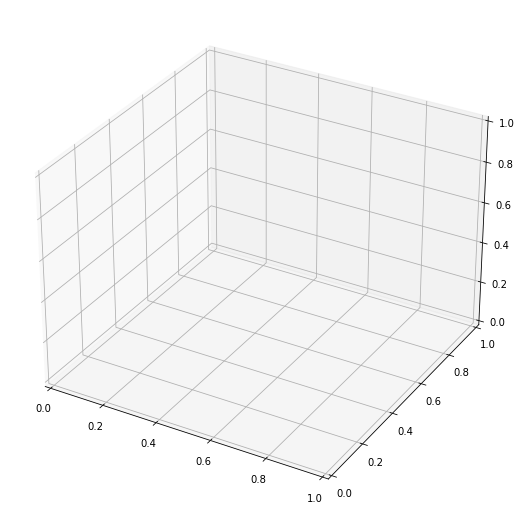

In [101]:
# %matplotlib notebook
%matplotlib inline
fig = plt.figure(figsize=(10,7))
ax = Axes3D(fig)

In [102]:
l=76
for t in range(l):
    gif_inspect(ax, time=t, save=False, event_no=138674361, hist=False, muon=1, n_neighbors=6, alpha=0.08)
    
# gif_inspect(ax, time=0, save=True, event_no=138674361, hist=False, muon=1, angle=10+3*t, n_neighbors=6)

Removed and ready to reload
Connecting to db-file
Reading files
   energy_log10    zenith   azimuth  direction_x  direction_y  direction_z
0      2.591801  0.819596  0.425762    -0.665621    -0.301861    -0.682516
Generating adjacency matrices
Saving dataset
Loading data to memory
Removed and ready to reload
Connecting to db-file
Reading files
   energy_log10    zenith   azimuth  direction_x  direction_y  direction_z
0      2.591801  0.819596  0.425762    -0.665621    -0.301861    -0.682516
Generating adjacency matrices
Saving dataset
Loading data to memory
Removed and ready to reload
Connecting to db-file
Reading files
   energy_log10    zenith   azimuth  direction_x  direction_y  direction_z
0      2.591801  0.819596  0.425762    -0.665621    -0.301861    -0.682516
Generating adjacency matrices
Saving dataset
Loading data to memory
Removed and ready to reload
Connecting to db-file
Reading files
   energy_log10    zenith   azimuth  direction_x  direction_y  direction_z
0      2.591801

Connecting to db-file
Reading files
   energy_log10    zenith   azimuth  direction_x  direction_y  direction_z
0      2.591801  0.819596  0.425762    -0.665621    -0.301861    -0.682516
Generating adjacency matrices
Saving dataset
Loading data to memory
Removed and ready to reload
Connecting to db-file
Reading files
   energy_log10    zenith   azimuth  direction_x  direction_y  direction_z
0      2.591801  0.819596  0.425762    -0.665621    -0.301861    -0.682516
Generating adjacency matrices
Saving dataset
Loading data to memory
Removed and ready to reload
Connecting to db-file
Reading files
   energy_log10    zenith   azimuth  direction_x  direction_y  direction_z
0      2.591801  0.819596  0.425762    -0.665621    -0.301861    -0.682516
Generating adjacency matrices
Saving dataset
Loading data to memory
Removed and ready to reload
Connecting to db-file
Reading files
   energy_log10    zenith   azimuth  direction_x  direction_y  direction_z
0      2.591801  0.819596  0.425762    -0.6

Removed and ready to reload
Connecting to db-file
Reading files
   energy_log10    zenith   azimuth  direction_x  direction_y  direction_z
0      2.591801  0.819596  0.425762    -0.665621    -0.301861    -0.682516
Generating adjacency matrices
Saving dataset
Loading data to memory
Removed and ready to reload
Connecting to db-file
Reading files
   energy_log10    zenith   azimuth  direction_x  direction_y  direction_z
0      2.591801  0.819596  0.425762    -0.665621    -0.301861    -0.682516
Generating adjacency matrices
Saving dataset
Loading data to memory
Removed and ready to reload
Connecting to db-file
Reading files
   energy_log10    zenith   azimuth  direction_x  direction_y  direction_z
0      2.591801  0.819596  0.425762    -0.665621    -0.301861    -0.682516
Generating adjacency matrices
Saving dataset
Loading data to memory
Removed and ready to reload
Connecting to db-file
Reading files
   energy_log10    zenith   azimuth  direction_x  direction_y  direction_z
0      2.591801

In [104]:
for t in range(l):
    gif_inspect(ax, time=t, save=True, event_no=138674361, hist=False, muon=1, angle=t*360/(l), n_neighbors=6)
    gif_inspect(ax, time=t, save=True, event_no=138674361, hist=False, muon=1, angle=t*360/(l)+1.6, n_neighbors=6)
    gif_inspect(ax, time=t, save=True, event_no=138674361, hist=False, muon=1, angle=t*360/(l)+3.2, n_neighbors=6)

Removed and ready to reload
Connecting to db-file
Reading files
   energy_log10    zenith   azimuth  direction_x  direction_y  direction_z
0      2.591801  0.819596  0.425762    -0.665621    -0.301861    -0.682516
Generating adjacency matrices
Saving dataset
Loading data to memory
Removed and ready to reload
Connecting to db-file
Reading files
   energy_log10    zenith   azimuth  direction_x  direction_y  direction_z
0      2.591801  0.819596  0.425762    -0.665621    -0.301861    -0.682516
Generating adjacency matrices
Saving dataset
Loading data to memory
Removed and ready to reload
Connecting to db-file
Reading files
   energy_log10    zenith   azimuth  direction_x  direction_y  direction_z
0      2.591801  0.819596  0.425762    -0.665621    -0.301861    -0.682516
Generating adjacency matrices
Saving dataset
Loading data to memory
Removed and ready to reload
Connecting to db-file
Reading files
   energy_log10    zenith   azimuth  direction_x  direction_y  direction_z
0      2.591801

Removed and ready to reload
Connecting to db-file
Reading files
   energy_log10    zenith   azimuth  direction_x  direction_y  direction_z
0      2.591801  0.819596  0.425762    -0.665621    -0.301861    -0.682516
Generating adjacency matrices
Saving dataset
Loading data to memory
Removed and ready to reload
Connecting to db-file
Reading files
   energy_log10    zenith   azimuth  direction_x  direction_y  direction_z
0      2.591801  0.819596  0.425762    -0.665621    -0.301861    -0.682516
Generating adjacency matrices
Saving dataset
Loading data to memory
Removed and ready to reload
Connecting to db-file
Reading files
   energy_log10    zenith   azimuth  direction_x  direction_y  direction_z
0      2.591801  0.819596  0.425762    -0.665621    -0.301861    -0.682516
Generating adjacency matrices
Saving dataset
Loading data to memory
Removed and ready to reload
Connecting to db-file
Reading files
   energy_log10    zenith   azimuth  direction_x  direction_y  direction_z
0      2.591801

Removed and ready to reload
Connecting to db-file
Reading files
   energy_log10    zenith   azimuth  direction_x  direction_y  direction_z
0      2.591801  0.819596  0.425762    -0.665621    -0.301861    -0.682516
Generating adjacency matrices
Saving dataset
Loading data to memory
Removed and ready to reload
Connecting to db-file
Reading files
   energy_log10    zenith   azimuth  direction_x  direction_y  direction_z
0      2.591801  0.819596  0.425762    -0.665621    -0.301861    -0.682516
Generating adjacency matrices
Saving dataset
Loading data to memory
Removed and ready to reload
Connecting to db-file
Reading files
   energy_log10    zenith   azimuth  direction_x  direction_y  direction_z
0      2.591801  0.819596  0.425762    -0.665621    -0.301861    -0.682516
Generating adjacency matrices
Saving dataset
Loading data to memory
Removed and ready to reload
Connecting to db-file
Reading files
   energy_log10    zenith   azimuth  direction_x  direction_y  direction_z
0      2.591801

Removed and ready to reload
Connecting to db-file
Reading files
   energy_log10    zenith   azimuth  direction_x  direction_y  direction_z
0      2.591801  0.819596  0.425762    -0.665621    -0.301861    -0.682516
Generating adjacency matrices
Saving dataset
Loading data to memory
Removed and ready to reload
Connecting to db-file
Reading files
   energy_log10    zenith   azimuth  direction_x  direction_y  direction_z
0      2.591801  0.819596  0.425762    -0.665621    -0.301861    -0.682516
Generating adjacency matrices
Saving dataset
Loading data to memory
Removed and ready to reload
Connecting to db-file
Reading files
   energy_log10    zenith   azimuth  direction_x  direction_y  direction_z
0      2.591801  0.819596  0.425762    -0.665621    -0.301861    -0.682516
Generating adjacency matrices
Saving dataset
Loading data to memory
Removed and ready to reload
Connecting to db-file
Reading files
   energy_log10    zenith   azimuth  direction_x  direction_y  direction_z
0      2.591801

Removed and ready to reload
Connecting to db-file
Reading files
   energy_log10    zenith   azimuth  direction_x  direction_y  direction_z
0      2.591801  0.819596  0.425762    -0.665621    -0.301861    -0.682516
Generating adjacency matrices
Saving dataset
Loading data to memory
Removed and ready to reload
Connecting to db-file
Reading files
   energy_log10    zenith   azimuth  direction_x  direction_y  direction_z
0      2.591801  0.819596  0.425762    -0.665621    -0.301861    -0.682516
Generating adjacency matrices
Saving dataset
Loading data to memory
Removed and ready to reload
Connecting to db-file
Reading files
   energy_log10    zenith   azimuth  direction_x  direction_y  direction_z
0      2.591801  0.819596  0.425762    -0.665621    -0.301861    -0.682516
Generating adjacency matrices
Saving dataset
Loading data to memory
Removed and ready to reload
Connecting to db-file
Reading files
   energy_log10    zenith   azimuth  direction_x  direction_y  direction_z
0      2.591801

Removed and ready to reload
Connecting to db-file
Reading files
   energy_log10    zenith   azimuth  direction_x  direction_y  direction_z
0      2.591801  0.819596  0.425762    -0.665621    -0.301861    -0.682516
Generating adjacency matrices
Saving dataset
Loading data to memory
Removed and ready to reload
Connecting to db-file
Reading files
   energy_log10    zenith   azimuth  direction_x  direction_y  direction_z
0      2.591801  0.819596  0.425762    -0.665621    -0.301861    -0.682516
Generating adjacency matrices
Saving dataset
Loading data to memory
Removed and ready to reload
Connecting to db-file
Reading files
   energy_log10    zenith   azimuth  direction_x  direction_y  direction_z
0      2.591801  0.819596  0.425762    -0.665621    -0.301861    -0.682516
Generating adjacency matrices
Saving dataset
Loading data to memory
Removed and ready to reload
Connecting to db-file
Reading files
   energy_log10    zenith   azimuth  direction_x  direction_y  direction_z
0      2.591801

Removed and ready to reload
Connecting to db-file
Reading files
   energy_log10    zenith   azimuth  direction_x  direction_y  direction_z
0      2.591801  0.819596  0.425762    -0.665621    -0.301861    -0.682516
Generating adjacency matrices
Saving dataset
Loading data to memory
Removed and ready to reload
Connecting to db-file
Reading files
   energy_log10    zenith   azimuth  direction_x  direction_y  direction_z
0      2.591801  0.819596  0.425762    -0.665621    -0.301861    -0.682516
Generating adjacency matrices
Saving dataset
Loading data to memory
Removed and ready to reload
Connecting to db-file
Reading files
   energy_log10    zenith   azimuth  direction_x  direction_y  direction_z
0      2.591801  0.819596  0.425762    -0.665621    -0.301861    -0.682516
Generating adjacency matrices
Saving dataset
Loading data to memory
Removed and ready to reload
Connecting to db-file
Reading files
   energy_log10    zenith   azimuth  direction_x  direction_y  direction_z
0      2.591801

Removed and ready to reload
Connecting to db-file
Reading files
   energy_log10    zenith   azimuth  direction_x  direction_y  direction_z
0      2.591801  0.819596  0.425762    -0.665621    -0.301861    -0.682516
Generating adjacency matrices
Saving dataset
Loading data to memory
Removed and ready to reload
Connecting to db-file
Reading files
   energy_log10    zenith   azimuth  direction_x  direction_y  direction_z
0      2.591801  0.819596  0.425762    -0.665621    -0.301861    -0.682516
Generating adjacency matrices
Saving dataset
Loading data to memory
Removed and ready to reload
Connecting to db-file
Reading files
   energy_log10    zenith   azimuth  direction_x  direction_y  direction_z
0      2.591801  0.819596  0.425762    -0.665621    -0.301861    -0.682516
Generating adjacency matrices
Saving dataset
Loading data to memory
Removed and ready to reload
Connecting to db-file
Reading files
   energy_log10    zenith   azimuth  direction_x  direction_y  direction_z
0      2.591801

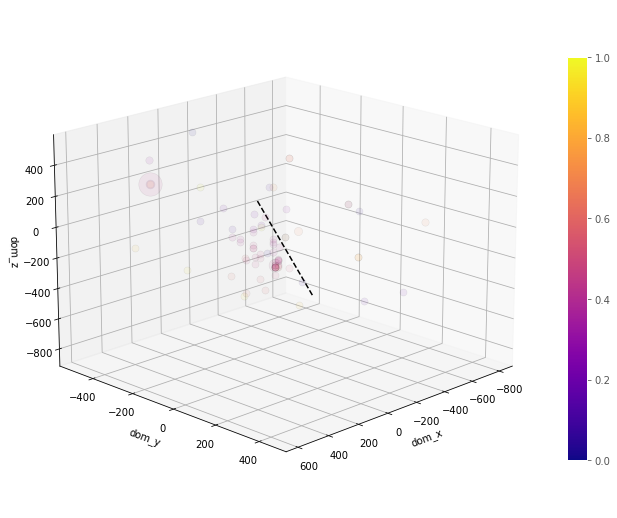

In [90]:
fig